In [1]:
# Libraries just used for producing graphics in the page, not used 
# by any of the exercises.
# install.packages('rnaturalearth')
# install.packages('rnaturalearthdata')
library(repr)
library(rnaturalearth)
library(rnaturalearthdata)

# Practical One: GIS data and plotting

## Required packages

There are loads of R packages that can load, manipulate and plot GIS data and we will be using several in this practical. In the last few years, the R spatial  data community has been working on bringing together most of the core GIS functionality into a few core packages. We will focus on using these up-to-date central packages, but there will be some occasions where we need to use older packages.

This quite a long list of packages - we've shown what each one does. If you are working on your own machine, you will need to install these packages using the code below, but they are pre-installed in the RStudio Cloud Projects.

```r <!-- This is nicely styled but not executed. Show don't run.-->
install.packages('raster') # Core raster GIS data package
install.packages('sf') # Core vector GIS data package
install.packages('sp') # Another core vector GIS package
install.packages('rgeos') # Extends vector data functionality
install.packages('rgdal') # Interface to the Geospatial Data Abstraction Library
install.packages('lwgeom') # Extends vector data functionality
```

To load the packages:

In [2]:
library(rgdal)
library(raster)
library(sf)
library(sp)
library(units)

Loading required package: sp



rgdal: version: 1.5-18, (SVN revision 1082)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 2.4.2, released 2019/06/28
Path to GDAL shared files: /Library/Frameworks/R.framework/Versions/3.6/Resources/library/rgdal/gdal
GDAL binary built with GEOS: FALSE 
Loaded PROJ runtime: Rel. 5.2.0, September 15th, 2018, [PJ_VERSION: 520]
Path to PROJ shared files: /Library/Frameworks/R.framework/Versions/3.6/Resources/library/rgdal/proj
Linking to sp version:1.4-4
Overwritten PROJ_LIB was /Library/Frameworks/R.framework/Versions/3.6/Resources/library/rgdal/proj



Linking to GEOS 3.7.2, GDAL 2.4.2, PROJ 5.2.0



udunits system database from /Library/Frameworks/R.framework/Versions/3.6/Resources/library/units/share/udunits



You will see a whole load of package loading messages about GDAL, GEOS, PROJ which are not shown here. Don't worry about this - they are not errors, just R linking to some key open source GIS toolkits.

## Vector data

We will mostly be using the more recent `sf` package to handle vector data. This replaces the  a lot of functionality in older packages like `sp` and `rgdal` under a more elegant and consistent interface. 

Note that in the background, all of these packages are just wrappers to the powerful, fast and open-source GIS libraries `gdal` (geospatial data handling), `geos` (vector data geometry) and `proj` (coordinate system projections).

The `sf` package is also used for most of the vector data GIS in the core textbook:

[https://geocompr.robinlovelace.net/index.html](https://geocompr.robinlovelace.net/index.html)

### Making vectors from coordinates

To start, let's create a population density map for the British Isles, using the data below:

In [3]:
pop_dens <- data.frame(n_km2 = c(260, 67,151, 4500, 133), 
                       country = c('England','Scotland', 'Wales', 'London', 'Northern Ireland'))
print(pop_dens)

  n_km2          country
1   260          England
2    67         Scotland
3   151            Wales
4  4500           London
5   133 Northern Ireland


We want to get polygon features that look *approximately*  like the map below. So, we are aiming to have separate polygons for Scotland, England, Wales, Northern Ireland and Eire. We also want to isolate London from the rest of England. This map is going to be *very* approximate and we're going to put the map together in a rather peculiar way, to show different geometry types and operations.

The map below looks a bit peculiar - squashed vertically - because it is plotting latitude and longitude degrees as if they are constant units and they are not. We'll come back to this in the section on reprojection below.

In [4]:
options(repr.plot.width=6, repr.plot.height= 5) # Change plot sizes (in cm)

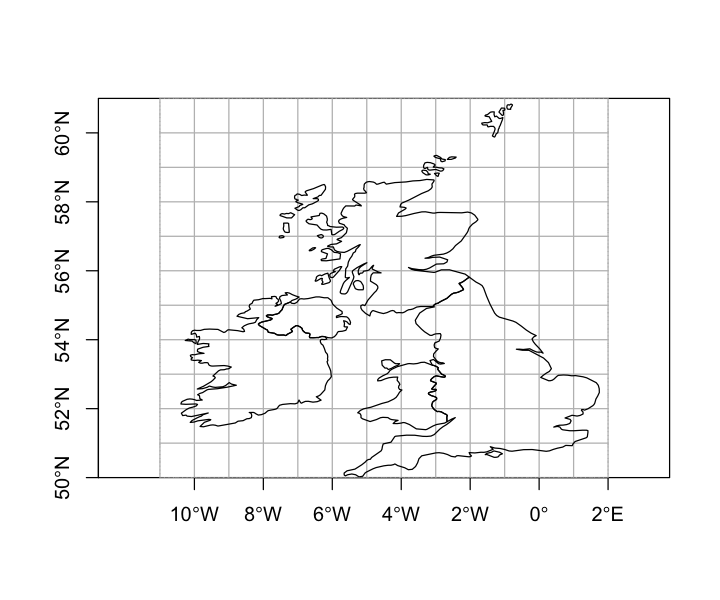

In [5]:
# Create a UK plot - code not seen by students
uk <- st_as_sf(ne_countries(country = c('united kingdom', 'ireland'), scale = 'medium', type='map_units'))
lat_b <- 50; lat_t <- 61; lon_l <- -11; lon_r <- 2
lats <- seq(lat_b, lat_t, by=1)
lons <- seq(lon_l, lon_r, by=1)
plot(st_geometry(st_graticule(x=c(lon_l, lat_b, lon_r, lat_t), crs=4326, lat=lats, lon=lons)),
     col='grey', xaxs='i', yaxs='i', asp=1, axes=TRUE)
plot(st_geometry(uk), add=TRUE)

In order to create vector data, we need to provide a set of coordinates for the points. For different kinds of vector geometries (POINT, LINESTRING, POLYGON), the coordinates are provided in different ways. Here, we are just using very simple polygons to show the countries.

In [6]:
# Create coordinates  for each country 
# - this creates a matrix of pairs of coordinates forming the edge of the polygon. 
# - note that they have to _close_: the first and last coordinate must be the same.
scotland <- rbind(c(-5, 58.6), c(-3, 58.6), c(-4, 57.6), 
                  c(-1.5, 57.6), c(-2, 55.8), c(-3, 55), 
                  c(-5, 55), c(-6, 56), c(-5, 58.6))
england <- rbind(c(-2,55.8),c(0.5, 52.8), c(1.6, 52.8), 
                  c(0.7, 50.7), c(-5.7,50), c(-2.7, 51.5), 
                  c(-3, 53.4),c(-3, 55), c(-2,55.8))
wales <- rbind(c(-2.5, 51.3), c(-5.3,51.8), c(-4.5, 53.4),
                  c(-2.8, 53.4),  c(-2.5, 51.3))
ireland <- rbind(c(-10,51.5), c(-10, 54.2), c(-7.5, 55.3),
                  c(-5.9, 55.3), c(-5.9, 52.2), c(-10,51.5))

# Convert these coordinates into feature geometries
# - these are simple coordinate sets with no projection information
scotland <- st_polygon(list(scotland))
england <- st_polygon(list(england))
wales <- st_polygon(list(wales))
ireland <- st_polygon(list(ireland))

We can combine these into a simple feature column (`sfc`), which also allows us to set the coordinate reference system (`crs` or projection) of the data. The mystery `4326` in the code below is explained later on! 

One other thing to note here is that `sf` automatically tries to scale the aspect ratio of plots of geographic coordinate data based on their latitude - this makes them look less squashed. We are actively suppressing that here by setting an aspect ratio of one (`asp=1`).

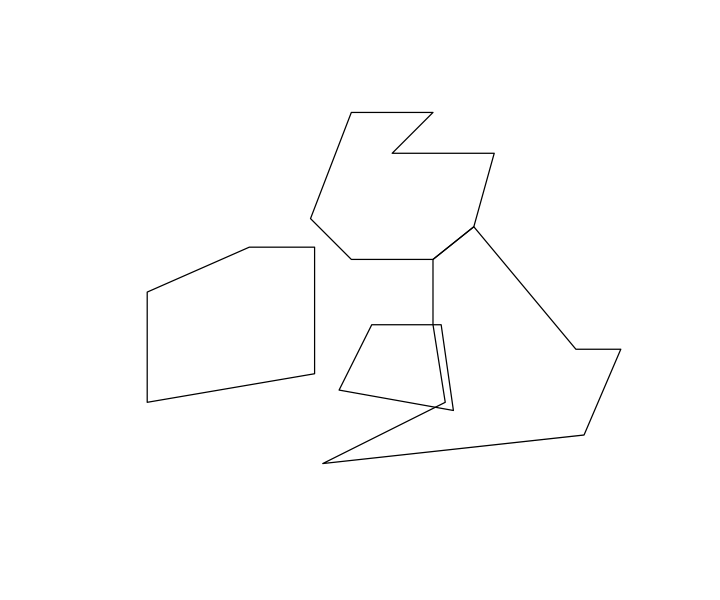

In [7]:
# Combine geometries into a simple feature column
uk_eire <- st_sfc(wales, england, scotland, ireland, crs=4326)
plot(uk_eire, asp=1)

### Making vector points from a dataframe

We can easily turn a data frame with coordinates in columns into a point vector data source. The example here creates point locations for capital cities.

In [8]:
uk_eire_capitals <- data.frame(long= c(-0.1, -3.2, -3.2, -6.0, -6.25),
                               lat=c(51.5, 51.5, 55.8, 54.6, 53.30),
                               name=c('London', 'Cardiff', 'Edinburgh', 'Belfast', 'Dublin'))

# Indicate which fields in the data frame contain the coordinates
uk_eire_capitals <- st_as_sf(uk_eire_capitals, coords=c('long','lat'), crs=4326)
print(uk_eire_capitals)

Simple feature collection with 5 features and 1 field
geometry type:  POINT
dimension:      XY
bbox:           xmin: -6.25 ymin: 51.5 xmax: -0.1 ymax: 55.8
CRS:            EPSG:4326
       name           geometry
1    London  POINT (-0.1 51.5)
2   Cardiff  POINT (-3.2 51.5)
3 Edinburgh  POINT (-3.2 55.8)
4   Belfast    POINT (-6 54.6)
5    Dublin POINT (-6.25 53.3)


### Vector geometry operations

That is a good start but we've got some issues:

1. We are missing a separate polygon for London.
2. The boundary for Wales is poorly digitized - we want a common border with England.
3. We have not separated Northern Ireland from Eire.

We'll handle those by using some geometry operations. First, we will use the **buffer** operation to create a polygon for London, which we define as anywhere within a quarter degree of St. Pauls Cathedral. This is a fairly stupid thing to do - we will come back to why later.

In [9]:
st_pauls <- st_point(x=c(-0.098056, 51.513611))
london <- st_buffer(st_pauls, 0.25)

We also need to remove London from the England polygon so that we can set different population densities for the two regions. This uses the **difference** operation. Note that the order of the arguments to this function matter: we want the bits of England that are different from London.

In [10]:
england_no_london <- st_difference(england, london)

Note that the resulting feature now has a different structure. The `lengths` function allows us to see the number of components in a polygon and how many points are in each component. If we look at the polygon for Scotland:

In [11]:
lengths(scotland)

[1] 18

There is a single component with 18 points. If we look at the new `england_no_london` feature:

In [12]:
lengths(england_no_london)

[1]  18 242

There are **two** components (or rings): one ring for the 18 points along the external border and a second ring of 242 points for the internal hole. Like `scotland`, all the other un-holey polygons only contain a single ring for their external border.

We can use the same operation to tidy up Wales: in this case we want the bits of Wales that are different from England.

In [13]:
wales <- st_difference(wales, england)

Now we will use the **intersection** operation to separate Northern Ireland from the island of Ireland. First we create a rough polygon that includes Northern Ireland and sticks out into the sea; then we find the intersection and difference of that with the Ireland polygon to get Northern Ireland and Eire.

In [14]:
# A rough polygon that includes Northern Ireland and surrounding sea.
# - not the alternative way of providing the coordinates
ni_area <- st_polygon(list(cbind(x=c(-8.1, -6, -5, -6, -8.1), y=c(54.4, 56, 55, 54, 54.4))))

northern_ireland <- st_intersection(ireland, ni_area)
eire <- st_difference(ireland, ni_area)

# Combine the final geometries
uk_eire <- st_sfc(wales, england_no_london, scotland, london, northern_ireland, eire, crs=4326)

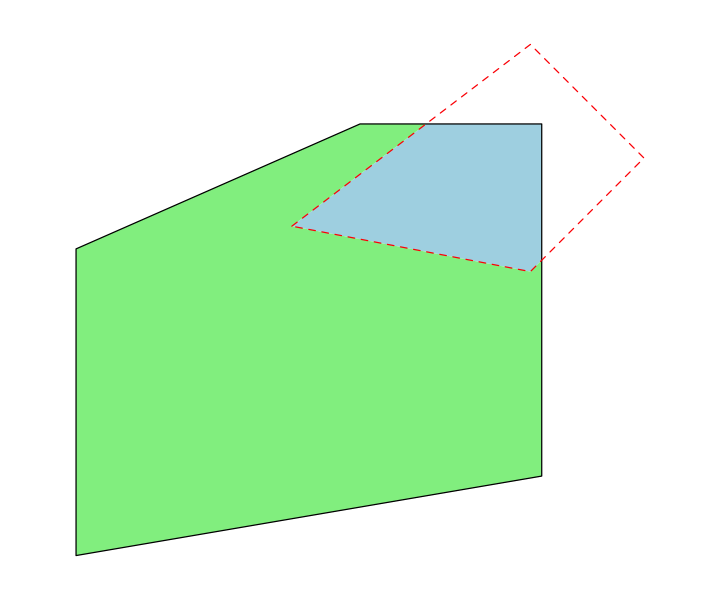

In [15]:
par( mar=c(1,1,1,1))
plot(northern_ireland, asp=1, ylim=c(51.5,56), xlim=c(-10, -5),  col='lightblue', border=NA)
plot(eire, add=TRUE, col='lightgreen', border=NA)
plot(ireland, add=TRUE)
plot(ni_area, add=TRUE, border='red', lty=2)

### Features and geometries 

That `uk_eire` object now contains 6 **features**: a feature is a set of one or more vector GIS geometries that represent a spatial unit we are interested in. At the moment, `uk_eire` hold six features, each of which consists of a single polygon. The England feature is slightly more complex because it as a hole in it. We can create a single feature that contains all of those geometries in one `MULTIPOLYGON` geometry by using the **union** operation:

In [16]:
# compare six Polygon features with one Multipolygon feature
print(uk_eire)

Geometry set for 6 features 
geometry type:  POLYGON
dimension:      XY
bbox:           xmin: -10 ymin: 50 xmax: 1.6 ymax: 58.6
CRS:            EPSG:4326
First 5 geometries:


POLYGON ((-2.942105 51.37895, -5.3 51.8, -4.5 5...



POLYGON ((-2 55.8, 0.5 52.8, 1.6 52.8, 0.7 50.7...



POLYGON ((-5 58.6, -3 58.6, -4 57.6, -1.5 57.6,...



POLYGON ((0.151944 51.51361, 0.1516014 51.50053...



POLYGON ((-6.91875 55.3, -5.9 55.3, -5.9 54.1, ...



In [17]:
# make the UK into a single feature
uk_country <- st_union(uk_eire[-6])
print(uk_country)

Geometry set for 1 feature 
geometry type:  MULTIPOLYGON
dimension:      XY
bbox:           xmin: -8.1 ymin: 50 xmax: 1.6 ymax: 58.6
CRS:            EPSG:4326


MULTIPOLYGON (((-6.91875 55.3, -5.9 55.3, -5.9 ...



In [18]:
options(repr.plot.width=7, repr.plot.height= 3) # Change plot sizes (in cm)

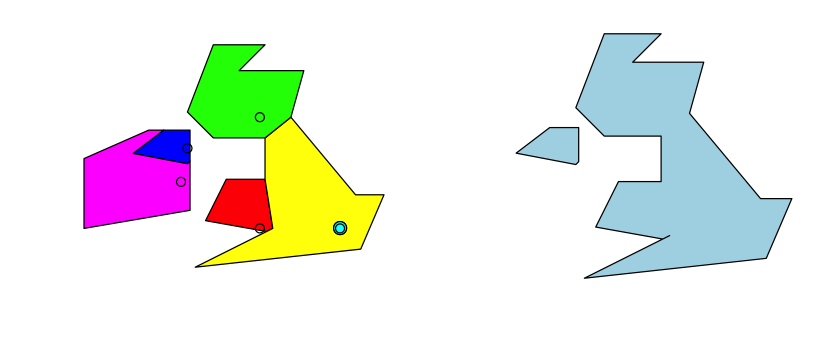

In [19]:
# Plot them
par(mfrow=c(1, 2), mar=c(3,3,1,1))
plot(uk_eire, asp=1, col=rainbow(6))
plot(st_geometry(uk_eire_capitals), add=TRUE)
plot(uk_country, asp=1, col='lightblue')

<!-- ## Geometry errors and validity

You can seen something odd about the `uk_country` map: it has a line at the southern end of the Welsh border. It is a bit like the Severn estuary, but If you zoom in on that area you would find it has basically zero width.

That isn't technically an error - it is just  that the vector processing is able to work with arbitrarily small differences and has preserved these two parallel edges. We can tidy it up by using a bit of a hack: buffer the whole feature by an arbitrarily small amount.

```{r validity}
#st_is_valid(uk_country)
#uk_country <- st_buffer(uk_country, 0.000001)
```

However, sometimes geometries are not valid, for example




Zooming in and exploring GIS data is one of the things that R is currently poor at - you are better off installing QGIS if you want to look over your data. -->


### Vector data and attributes

So far we just have the vector geometries, but GIS data is about pairing spatial features with data about those features, often called *attributes* or *properties*. The `sf` package introduces the `sf` object type: basically this is just a normal data frame with an additional field containing **simple feature** data. We can do that here:

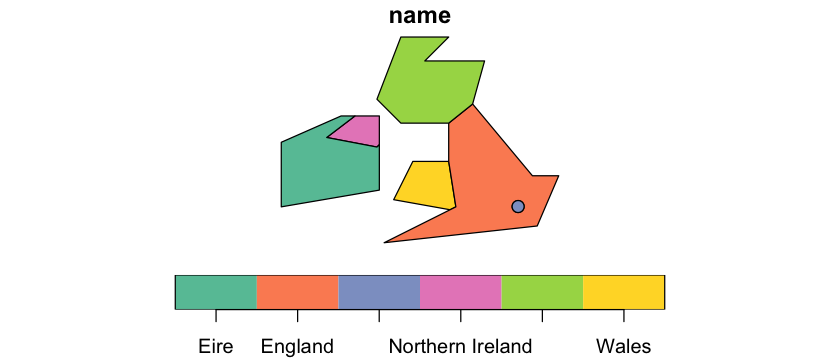

In [20]:
uk_eire <- st_sf(name=c('Wales', 'England','Scotland', 'London', 
                        'Northern Ireland', 'Eire'),
                 geometry=uk_eire)

plot(uk_eire, asp=1)

Since an `sf` object is an extended data frame, we can add attributes by adding fields directly:

In [21]:
uk_eire$capital <- c('Cardiff', 'London', 'Edinburgh', 
                     NA, 'Belfast','Dublin')
print(uk_eire)

Simple feature collection with 6 features and 2 fields
geometry type:  POLYGON
dimension:      XY
bbox:           xmin: -10 ymin: 50 xmax: 1.6 ymax: 58.6
CRS:            EPSG:4326
              name                       geometry   capital
1            Wales POLYGON ((-2.942105 51.3789...   Cardiff
2          England POLYGON ((-2 55.8, 0.5 52.8...    London
3         Scotland POLYGON ((-5 58.6, -3 58.6,... Edinburgh
4           London POLYGON ((0.151944 51.51361...      <NA>
5 Northern Ireland POLYGON ((-6.91875 55.3, -5...   Belfast
6             Eire POLYGON ((-10 51.5, -10 54....    Dublin


A more useful - and less error prone - technique is to use the `merge` command to match data in from the `pop_dens` data frame. The `merge` function allows us to set columns in two data frames that containing matching values and uses those to merge the data together. 

* We need to use `by.x` and `by.y` to say which columns we expect to match, but if the column names were identical in the two frames, we could just use `by`. 
* The default for `merge` is to drop rows when it doesn't find matching data. So here, we have to also use `all.x=TRUE`, otherwise Eire will be dropped from the spatial data because it has no population density estimate in the data frame. 

If we look at the result, we get some header information about the spatial data and then something that looks very like a data frame printout, with the extra `geometry` column.

In [22]:
uk_eire <- merge(uk_eire, pop_dens, by.x='name', by.y='country', all.x=TRUE)
print(uk_eire)

Simple feature collection with 6 features and 3 fields
geometry type:  POLYGON
dimension:      XY
bbox:           xmin: -10 ymin: 50 xmax: 1.6 ymax: 58.6
CRS:            EPSG:4326
              name   capital n_km2                       geometry
1             Eire    Dublin    NA POLYGON ((-10 51.5, -10 54....
2          England    London   260 POLYGON ((-2 55.8, 0.5 52.8...
3           London      <NA>  4500 POLYGON ((0.151944 51.51361...
4 Northern Ireland   Belfast   133 POLYGON ((-6.91875 55.3, -5...
5         Scotland Edinburgh    67 POLYGON ((-5 58.6, -3 58.6,...
6            Wales   Cardiff   151 POLYGON ((-2.942105 51.3789...


### Spatial attributes

One common thing that people want to know are spatial attributes of geometries and there are a range of commands to find these things out. One thing we might want are the **centroids** of features.

In [23]:
st_agr(uk_eire) <- 'constant'

In [24]:
uk_eire_centroids <- st_centroid(uk_eire)
st_coordinates(uk_eire_centroids)

Warning message in st_centroid.sfc(st_geometry(x), of_largest_polygon = of_largest_polygon):
“st_centroid does not give correct centroids for longitude/latitude data”


,X,Y
1,-8.102211,53.20399
2,-1.479850,52.43729
3,-0.098056,51.51361
4,-6.717310,54.66788
5,-3.867713,56.65262
6,-3.854234,52.39819


The `sf` package warns us here that this isn't a sensible thing to do. There isn't a good way to calculate a true centroid for geographic coordinates - we'll come back to this in the section on reprojection. 

Two other simple ones are the **length** of a feature and its **area**. Note that here `sf` is able to do something clever behind the scenes. Rather than give us answers in units of degrees, it notes that we have a goegraphic coordinate system and instead uses internal transformations to give us back accurate distances and areas using metres. Under the hood, it is using calculations on the surface of a sphere, so called [great circle distances](https://en.wikipedia.org/wiki/Great-circle_distance).

In [25]:
uk_eire$area <- st_area(uk_eire)
# The length of a polygon is the perimeter length 
# - note that this includes the length of internal holes.
uk_eire$length <- st_length(uk_eire)
# Look at the result
print(uk_eire)

Simple feature collection with 6 features and 5 fields
Attribute-geometry relationship: 3 constant, 0 aggregate, 0 identity, 2 NA's
geometry type:  POLYGON
dimension:      XY
bbox:           xmin: -10 ymin: 50 xmax: 1.6 ymax: 58.6
CRS:            EPSG:4326
              name   capital n_km2                       geometry
1             Eire    Dublin    NA POLYGON ((-10 51.5, -10 54....
2          England    London   260 POLYGON ((-2 55.8, 0.5 52.8...
3           London      <NA>  4500 POLYGON ((0.151944 51.51361...
4 Northern Ireland   Belfast   133 POLYGON ((-6.91875 55.3, -5...
5         Scotland Edinburgh    67 POLYGON ((-5 58.6, -3 58.6,...
6            Wales   Cardiff   151 POLYGON ((-2.942105 51.3789...
                area        length
1  80555367364 [m^2] 1326763.9 [m]
2 125982254516 [m^2] 2062484.3 [m]
3   1515812620 [m^2]  143796.2 [m]
4  13656055128 [m^2]  480968.2 [m]
5  76276260910 [m^2] 1255577.2 [m]
6  28948401464 [m^2]  689831.5 [m]


Notice that those fields display units after the values. The `sf` package often creates data with explicit units, using the `units` package. That is nicely precise but you may need to know how to handle the values:

In [26]:
# You can change units in a neat way
uk_eire$area <- set_units(uk_eire$area, 'km^2')
uk_eire$length <- set_units(uk_eire$length, 'km')
print(uk_eire)

Simple feature collection with 6 features and 5 fields
Attribute-geometry relationship: 3 constant, 0 aggregate, 0 identity, 2 NA's
geometry type:  POLYGON
dimension:      XY
bbox:           xmin: -10 ymin: 50 xmax: 1.6 ymax: 58.6
CRS:            EPSG:4326
              name   capital n_km2                       geometry
1             Eire    Dublin    NA POLYGON ((-10 51.5, -10 54....
2          England    London   260 POLYGON ((-2 55.8, 0.5 52.8...
3           London      <NA>  4500 POLYGON ((0.151944 51.51361...
4 Northern Ireland   Belfast   133 POLYGON ((-6.91875 55.3, -5...
5         Scotland Edinburgh    67 POLYGON ((-5 58.6, -3 58.6,...
6            Wales   Cardiff   151 POLYGON ((-2.942105 51.3789...
               area         length
1  80555.367 [km^2] 1326.7639 [km]
2 125982.255 [km^2] 2062.4843 [km]
3   1515.813 [km^2]  143.7962 [km]
4  13656.055 [km^2]  480.9682 [km]
5  76276.261 [km^2] 1255.5772 [km]
6  28948.401 [km^2]  689.8315 [km]


In [27]:
# And it won't let you make silly error like turning a length into weight
uk_eire$area <- set_units(uk_eire$area, 'kg')

ERROR: Error: cannot convert km^2 into kg


In [28]:
# Or you can simply convert the `units` version to simple numbers
uk_eire$length <- as.numeric(uk_eire$length)

A final useful example is the **distance** between objects: `sf` gives us the closest distance between geometries, which might be zero if two features overlap or touch, as in the neighbouring polygons in our data.

In [29]:
st_distance(uk_eire)

Units: [m]
          [,1]     [,2]     [,3]      [,4]      [,5]      [,6]
[1,]      0.00 189660.5 388874.5      0.00  89305.75  52085.08
[2,] 189660.51      0.0      0.0 185529.79      0.00      0.00
[3,] 388874.46      0.0      0.0 463253.57 407423.19 163295.88
[4,]      0.00 185529.8 463253.6      0.00  33455.33 119471.08
[5,]  89305.75      0.0 407423.2  33455.33      0.00 178084.13
[6,]  52085.08      0.0 163295.9 119471.08 178084.13      0.00

In [30]:
st_distance(uk_eire_centroids)

Units: [m]
         [,1]     [,2]     [,3]     [,4]     [,5]     [,6]
[1,]      0.0 454351.6 576456.5 186596.2 469999.3 300157.7
[2,] 454351.6      0.0 139917.3 426582.5 493943.0 161597.1
[3,] 576456.5 139917.3      0.0 565182.7 622706.0 276301.1
[4,] 186596.2 426582.5 565182.7      0.0 284546.5 315936.9
[5,] 469999.3 493943.0 622706.0 284546.5      0.0 473581.0
[6,] 300157.7 161597.1 276301.1 315936.9 473581.0      0.0

Again, `sf` is noting that we have a geographic coordinate system and internally calculating distances in metres. 


### Plotting `sf` objects

If you plot an `sf` object, the default is to plot a map for every attribute. You can pick a field to plot by using square brackets. So, now we can show our map of population density:

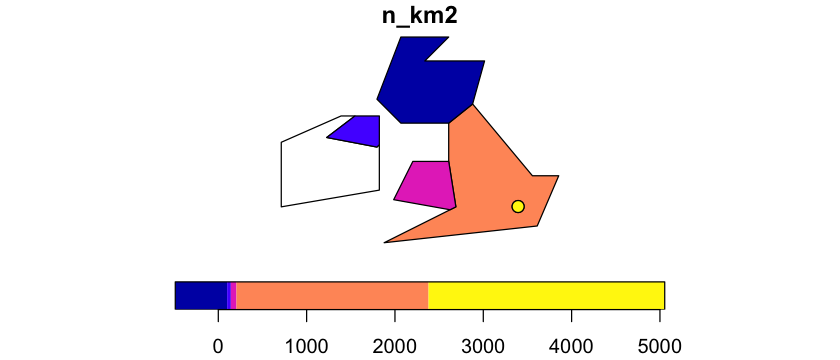

In [31]:
plot(uk_eire['n_km2'], asp=1)

If you  just want to plot the geometries, without any labelling or colours, the `st_geometry` function can be used to temporarily strip off attributes - see the reprojection section below for an example. 

```{admonition} Scale the legend
The scale on that plot isn't very helpful. Look at `?plot.sf` and see if you can get a log scale on the right.
```

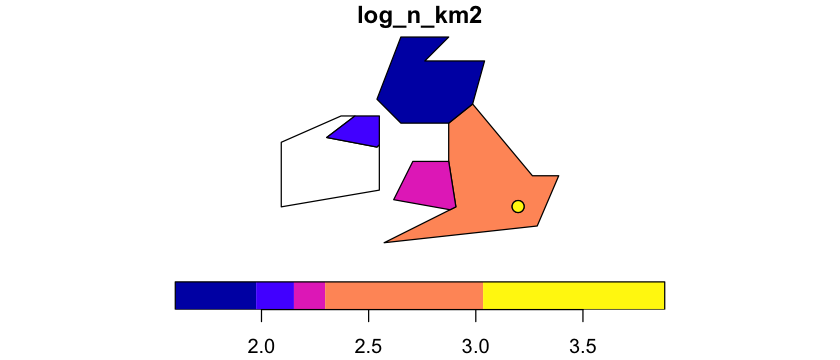

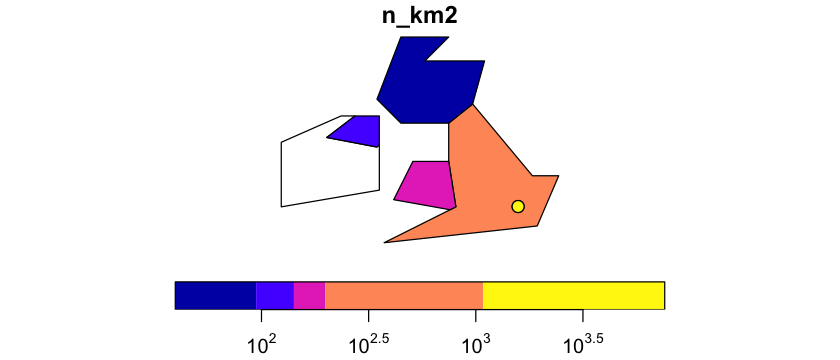

In [32]:
par(mfrow=c(1,2))
# You could simply log the data:
uk_eire$log_n_km2 <- log10(uk_eire$n_km2)
plot(uk_eire['log_n_km2'], asp=1)
# Or you can have logarithimic labelling using logz
plot(uk_eire['n_km2'], asp=1, logz=TRUE)

### Reprojecting vector data

First, in the examples above we have been **asserting** that we have data with a particular projection (`4326`). This is **not** reprojection: we are simply saying that we know these coordinates are in this projection and setting that projection. 

That mysterious `4326` is just a unique numeric code in the EPSG database of spatial coordinate systems: [http://epsg.io/](). The code acts a shortcut for the often complicated sets of parameters and transformations that define a particular projection. Here `4326` is the [WGS84](http://epsg.io/4326) geographic coordinate system which is extremely widely used. Most GPS data is collected in WGS84, for example.

Reprojection is moving data from one set of coordinates to another. For vector data, this is a relatively straightforward process. The spatial information in a vector dataset are coordinates in space, and projections are just sets of equations, so it is simple to apply the equations to the coordinates. We'll come back to this for raster data: coordinate transormation is identical but transforming the data stored in a raster is conceptually more complex.

Reprojecting data is often used to convert from a geographic coordinate system - with units of degrees - to a projected coordinate system with linear units. Remember that projected coordinate systems are always a trade off between conserving distance, shape, area and bearings and it is important to pick one that is appropriate to your area or analysis.

 We will reproject our UK and Eire map onto a good choice of local projected coordinate system: the [British National Grid](http://epsg.io/27700). We can also use a bad choice: the [UTM 50N](http://epsg.io/32650) projection, which is appropriate for Borneo. It does not end well if we use it to project the UK and Eire.

In [33]:
# British National Grid (EPSG:27700)
uk_eire_BNG <- st_transform(uk_eire, 27700)
# UTM50N (EPSG:32650)
uk_eire_UTM50N <- st_transform(uk_eire, 32650)
# The bounding boxes of the data shows the change in units
st_bbox(uk_eire)

 xmin  ymin  xmax  ymax 
-10.0  50.0   1.6  58.6 

In [34]:
st_bbox(uk_eire_BNG)

      xmin       ymin       xmax       ymax 
-154811.97   17655.72  642773.71  971900.65 

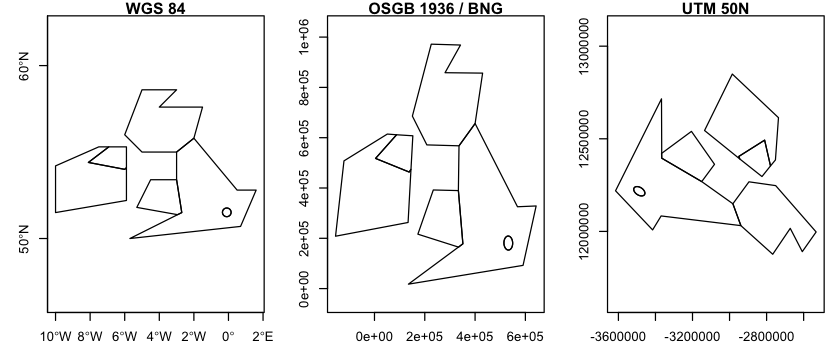

In [35]:
# Plot the results
par(mfrow=c(1, 3), mar=c(3,3,1,1))
plot(st_geometry(uk_eire), asp=1, axes=TRUE, main='WGS 84')
plot(st_geometry(uk_eire_BNG), axes=TRUE, main='OSGB 1936 / BNG')
plot(st_geometry(uk_eire_UTM50N), axes=TRUE, main='UTM 50N')

#### Proj4 strings

Those EPSG ID codes save us from `proj4` strings (see [here](https://proj.org/)): these text strings contain often long and confusing sets of options and parameters that actually define a particular projection. The `sf` package is kind to us, but some other packages are not, so you may see these in R and you can also see the `proj4` strings on the EPSG website:

* **4326**: `+init=EPSG:4326 +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0`
* **27700**: `+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000+ellps=airy`  
          `+towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs`
* **32650**: `+proj=utm +zone=50 +datum=WGS84 +units=m +no_defs`

#### Degrees are not constant

The units of geographic coordinate systems are **angles** of latitide and longitude. These are not a constant unit of distance and as lines of longitude converge towards to pole, the physical length of a degree decreases.  This is why our 0.25° buffered point for London is stupid and why it is distorted in the projected data. 

At the latitude of London, a degree longitude is about 69km and a degree latitude is about 111 km. Again `st_distance` is noting that we have geographic coordinates and is returning great circle distances in metres.

In [36]:
# Set up some points separated by 1 degree latitude and longitude from St. Pauls
st_pauls <- st_sfc(st_pauls, crs=4326)
one_deg_west_pt <- st_sfc(st_pauls - c(1, 0), crs=4326) # near Goring
one_deg_north_pt <-  st_sfc(st_pauls + c(0, 1), crs=4326) # near Peterborough
# Calculate the distance between St Pauls and each point
st_distance(st_pauls, one_deg_west_pt)

Units: [m]
         [,1]
[1,] 69419.29

In [37]:
st_distance(st_pauls, one_deg_north_pt)

Units: [m]
         [,1]
[1,] 111267.6

Note that the great circle distance between London and Goring - which accounts for the curvature of the earth  - is roughly 17 metres longer than the distance between the same coordinates projected onto the British National Grid.

In [38]:
st_distance(st_transform(st_pauls, 27700), 
            st_transform(one_deg_west_pt, 27700))

Units: [m]
         [,1]
[1,] 69401.97

```{admonition} Improve the London feature
Our feature for London would be far better if it used a constant 25km buffer around St. Pauls, rather than the poor atttempt using degrees. The resulting map is below - try to recreate it.
```

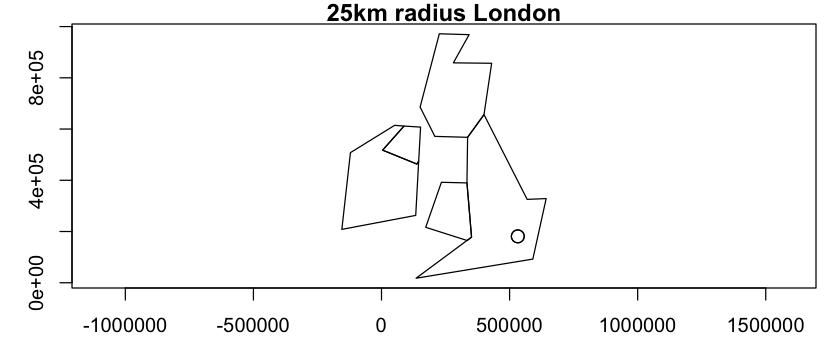

In [39]:
# transform St Pauls to BNG and buffer using 25 km
london_bng <- st_buffer(st_transform(st_pauls, 27700), 25000)
# In one line, transform england to BNG and cut out London
england_not_london_bng <- st_difference(st_transform(st_sfc(england, crs=4326), 27700), london_bng)
# project the other features and combine everything together
others_bng <- st_transform(st_sfc(eire, northern_ireland, scotland, wales, crs=4326), 27700)
corrected <- c(others_bng, london_bng, england_not_london_bng)
# Plot that and marvel at the nice circular feature around London
par(mar=c(3,3,1,1))
plot(corrected, main='25km radius London', axes=TRUE)

## Rasters

Rasters are the other major type of spatial data. They consist of a regular grid in space, defined by a coordinate system, an origin point, a resolution and a number of rows and columns. They effectively hold a matrix of data. We will use the `raster` package to handle raster data.

### Creating a raster

We are first going to build a simple raster dataset from scratch. We are setting the projection, the bounds and the resolution. The raster object initially has no data values associated with it, but we can set them.

Note that the `raster` package doesn't support using EPSG codes as numbers, but does support them as a formatted text string: `+init=EPSG:4326`.

In [40]:
# Create an empty raster object covering UK and Eire
uk_raster_WGS84 <- raster(xmn=-11,  xmx=2,  ymn=49.5, ymx=59, 
                          res=0.5, crs="+init=EPSG:4326")
hasValues(uk_raster_WGS84)

[1] FALSE

In [41]:
# Add data to the raster: just the number 1 to number of cells
values(uk_raster_WGS84) <- seq(length(uk_raster_WGS84))
print(uk_raster_WGS84)

class      : RasterLayer 
dimensions : 19, 26, 494  (nrow, ncol, ncell)
resolution : 0.5, 0.5  (x, y)
extent     : -11, 2, 49.5, 59  (xmin, xmax, ymin, ymax)
crs        : +init=EPSG:4326 +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0 
source     : memory
names      : layer 
values     : 1, 494  (min, max)



We can create a basic map of that, with the country borders over the top: `add=TRUE` adds the vector data to the existing map and the other options set border and fill colours. The ugly looking `#FFFFFF44` is a [RGBA colour code](https://en.wikipedia.org/wiki/RGBA_color_space#RGBA_hexadecimal_(word-order)) that gives us a transparent gray fill for the polygon.

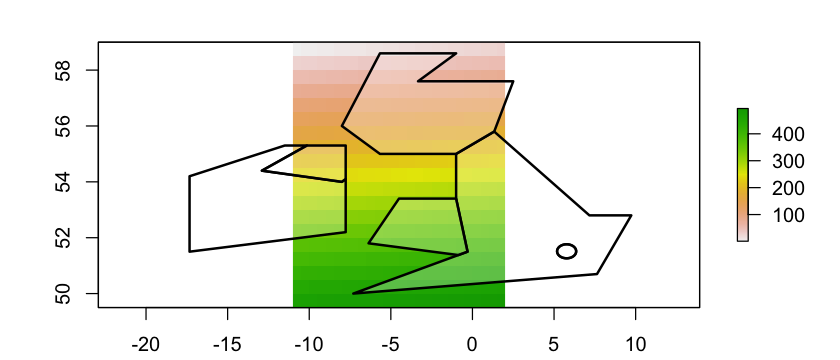

In [42]:
plot(uk_raster_WGS84)
plot(st_geometry(uk_eire), add=TRUE, border='black', lwd=2, col='#FFFFFF44')

### Changing raster resolution

You can change a raster to have either coarser or finer resolution, but you have to **think** about what the data is and what it means when you *aggregate* or *disaggregate* the values. You might need to do this to make different data sources have the same resolution for an analysis, or because the data you are using is more detailed than you need or can analyse.

We'll use a really simple example:

In [43]:
# Define a simple 4 x 4 square raster
m <- matrix(c(1, 1, 3, 3,
              1, 2, 4, 3,
              5, 5, 7, 8,
              6, 6, 7, 7), ncol=4, byrow=TRUE)
square <- raster(m)

### Aggregating rasters

With aggregating, we choose an aggregation *factor* - how many cells to group - and then lump sets of cells together. So, for example, a factor of 2 will aggregate blocks of 2x2 cells. 

The question is then, what value should we assign? If the data is continuous (e.g. height) then a mean or a maximum might make sense. However if the raster values represent categories (like land cover), then mean doesn't make sense _at all_: the average of Forest (2) and  Moorland (3) codes is easy to calculate but is meaningless!

In [44]:
# Average values
square_agg_mean <- aggregate(square, fact=2, fun=mean)
as.matrix(square_agg_mean)

1.25,3.25
5.50,7.25


In [45]:
# Maximum values
square_agg_max <- aggregate(square, fact=2, fun=max)
as.matrix(square_agg_max)

2,4
6,8


In [46]:
# Modal values for categories
square_agg_modal <- aggregate(square, fact=2, fun=modal)
as.matrix(square_agg_modal)

1,3
6,7


```{admonition} Issues with aggregation
Even using the modal value, there is a problem with aggregating rasters with categories. This occurs in the example data - can you see what it is?
```

```{toggle}
The bottom left cell has a modal value of 5 even though there is no mode: there are two 5s and two 6s. You can use `first` and `last` to specify which value gets chosen but strictly there is no single mode.
```

### Disaggregating rasters

The `disaggregate` function also requires a factor, but this time the factor is the square root of the number of cells to _create_ from each cell, rather than the number to merge. There is again a choice to make on what values to put in the cell. The obvious answer is simply to copy the parent cell value into each of the new cells: this is pretty simple and is fine for both continuous and categorical values. Another option is to **interpolate** between the values to provide a smoother gradient between cells. This does **not** make sense for a categorical variable.

In [47]:
# Copy parents
square_disagg <- disaggregate(square, fact=2)
# Interpolate
square_disagg_interp <- disaggregate(square, fact=2, method='bilinear')

We'll show those values visually:

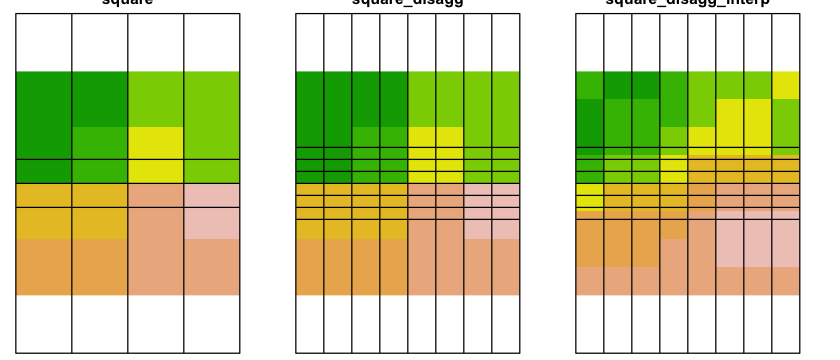

In [48]:
par(mfrow=c(1,3), mar=c(1,1,2,1))
cols <- terrain.colors(9)
bks <- 0:8
plot(square, main='square', col=cols, breaks=bks, axes=FALSE, legend=FALSE)
abline(h=1:3/4, v=1:3/4)
# plot(square_agg_mean, main='square_agg_mean', col=cols, breaks=bks)
# abline(h=1/2, v=1/2)
# plot(square_agg_max, main='square_agg_max', col=cols, breaks=bks)
# abline(h=1/2, v=1/2)
# plot(square_agg_modal, main='square_agg_mode', col=cols, breaks=bks)
# abline(h=1/2, v=1/2)
plot(square_disagg, main='square_disagg', col=cols, breaks=bks, axes=FALSE, legend=FALSE)
abline(h=1:7/8, v=1:7/8)
plot(square_disagg_interp, main='square_disagg_interp', col=cols, breaks=bks, axes=FALSE, legend=FALSE)
abline(h=1:7/8, v=1:7/8)

### Resampling

Note that the previous two functions don't change the **origin** or **alignments of cell borders** at all: they just lump or split values within the same grid framework.  If you need to match datasets and they have different origins and alignments then you need to use the more complex `resample` function. We won't look at this further here because it is basically a simpler case of ...

### Reprojecting a raster

This is conceptually more difficult than reprojecting vector data but we've covered the main reasons above. You have a series of raster cell values in one projection and then want to insert representative values into a set of cells on a different projection. The borders of those new cells could have all sorts of odd relationships to the current ones.

In the example here, we are show how our 0.5° WGS84 raster for the UK and Eire compares to a 100km resolution raster on the British National Grid. 

We can't display that using actual raster data because they always need to plot on a regular grid. However we can create vector grids, using the new function `st_make_grid` and our other vector tools, to represent the cells in the two raster grids so we can overplot them. You can see how transferring cell values between those two raster grids gets complicated!

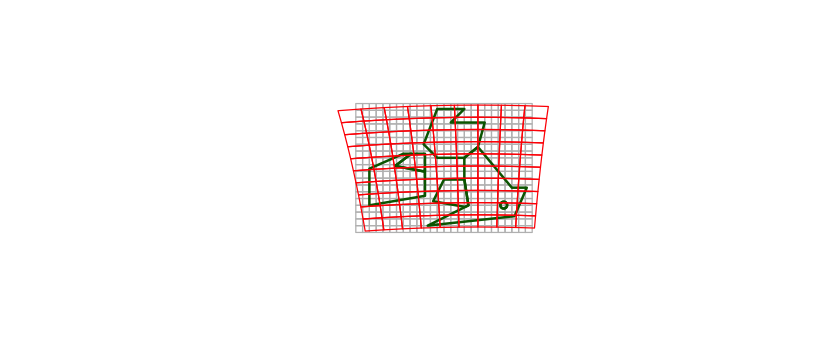

In [49]:
# make two simple `sfc` objects containing points in  the
# lower left and top right of the two grids
uk_pts_WGS84 <- st_sfc(st_point(c(-11, 49.5)), st_point(c(2, 59)), crs=4326)
uk_pts_BNG <- st_sfc(st_point(c(-2e5, 0)), st_point(c(7e5, 1e6)), crs=27700)

#  Use st_make_grid to quickly create a polygon grid with the right cellsize
uk_grid_WGS84 <- st_make_grid(uk_pts_WGS84, cellsize=0.5)
uk_grid_BNG <- st_make_grid(uk_pts_BNG, cellsize=1e5)

# Reproject BNG grid into WGS84
uk_grid_BNG_as_WGS84 <- st_transform(uk_grid_BNG, 4326)

# Plot the features
plot(uk_grid_WGS84, asp=1, border='grey', xlim=c(-13,4))
plot(st_geometry(uk_eire), add=TRUE, border='darkgreen', lwd=2)
plot(uk_grid_BNG_as_WGS84, border='red', add=TRUE)

We will use the `projectRaster` function, which gives us the choice of interpolating a representative value from the source data (`method='bilinear'`) or picking the cell value from the nearest neighbour to the new cell centre (`method='ngb'`). We first create the target raster - we don't have to put any data into it - and use that as a template for the reprojected data.

In [50]:
# Create the target raster
uk_raster_BNG <- raster(xmn=-200000, xmx=700000, ymn=0, ymx=1000000,
                         res=100000, crs='+init=EPSG:27700')
uk_raster_BNG_interp <- projectRaster(uk_raster_WGS84, uk_raster_BNG, method='bilinear')
uk_raster_BNG_ngb <- projectRaster(uk_raster_WGS84, uk_raster_BNG, method='ngb')
# compare the values in the top row
round(values(uk_raster_BNG_interp)[1:9], 2)
values(uk_raster_BNG_ngb)[1:9]

[1]    NA 31.36 30.02 29.87 30.91 33.14 36.56 41.17    NA

[1] NA 29 33 36 39 43 46 50 NA

Note the `NA` in the cell values in the top right and left. In the plot above, you can see that the centres of those red cells do not overlie the original grey grid and `projectRaster` has assigned an `NA` value. If we plot the two outputs you can see the more abrupt changes when using nearest neighbour reprojection.

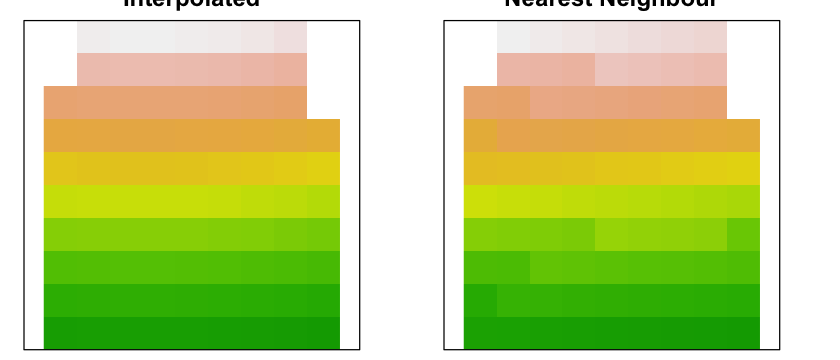

In [51]:
par(mfrow=c(1,2), mar=c(1,1,2,1))
plot(uk_raster_BNG_interp, main='Interpolated', axes=FALSE, legend=FALSE)
plot(uk_raster_BNG_ngb, main='Nearest Neighbour',axes=FALSE, legend=FALSE)

For a recent package with a strong focus on raster data handling, go and have a look at the `stars` package: [https://r-spatial.github.io/stars/](https://r-spatial.github.io/stars/).

## Converting between vector and raster data types

Sometimes you want to represent raster data in vector format or vice versa. It is usually worth thinking if you really want to do this - data usually comes in one format or another for a reason - but there are plenty of valid reasons to do it.

### Vector to raster

Converting vector data to a raster is a bit like `reprojectRaster`: you provide the target raster and the vector data and put it all through the `rasterize` function. There are important differences in the way that different geometry types get rasterized. In each case, a vector attribute is chosen to assign cell values in ther raster.

* **POINT**: If a point falls anywhere within a cell, that value is assigned to the cell.
* **LINESTRING**: If any part of the linestring falls within a cell, that value is assigned to the cell.
* **POLYGON**: If the centre of the cell falls within a polygon, the value from that polygon is assigned to the cell.

It is common that a cell might have more than one possible value - for example if two points fall in a cell. The `rasterize` function has a `fun` argument that allows you to set rules to decide which value 'wins'.

One problem here is that `raster` predates `sf` and wants the vector data in the older `Spatial` data type from the `sp` package. Fortunately, that is easy to convert: `as(sf_object, 'Spatial')` does the trick.

We'll rasterize the `uk_eire_BNG` vector data onto a 20km resolution grid. We will also use the `st_cast` function to change the polygon data into lines and points, to show the differences in the outcome.

In [52]:
# Create the target raster 
uk_20km <- raster(xmn=-200000, xmx=650000, ymn=0, ymx=1000000, 
                  res=20000, crs='+init=EPSG:27700')

# Rasterizing polygons
uk_eire_poly_20km  <- rasterize(as(uk_eire_BNG, 'Spatial'), uk_20km, field='name')

# Rasterizing lines
uk_eire_BNG_line <- st_cast(uk_eire_BNG, 'LINESTRING')

Warning message in st_cast.sf(uk_eire_BNG, "LINESTRING"):
“repeating attributes for all sub-geometries for which they may not be constant”


One excellent feature of the `sf` package is the sheer quantity of warnings it will issue to avoid making errors. When you alter geometries, it isn't always clear that the attributes of the original geometry apply to the altered geometries.  Here, we are being warned that the country attributes might not apply to the lines. We can use the `st_agr` function to tell `sf` that attributes *are* constant and it will stop warning us.

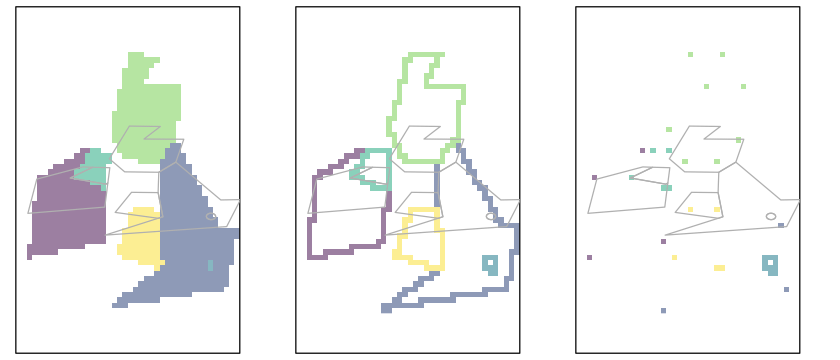

In [53]:
st_agr(uk_eire_BNG) <- 'constant'

# Rasterizing lines
uk_eire_BNG_line <- st_cast(uk_eire_BNG, 'LINESTRING')
uk_eire_line_20km <- rasterize(as(uk_eire_BNG_line, 'Spatial'), uk_20km, field='name')

# Rasterizing points 
# - This isn't quite as neat. You need to take two steps in the cast and need to convert 
#   the name factor to numeric.
uk_eire_BNG_point <- st_cast(st_cast(uk_eire_BNG, 'MULTIPOINT'), 'POINT')
uk_eire_BNG_point$name <- as.numeric(uk_eire_BNG_point$name)
uk_eire_point_20km <- rasterize(as(uk_eire_BNG_point, 'Spatial'), uk_20km, field='name')

# Plotting those different outcomes
# - Use the hcl.colors function to create a nice plotting palette
color_palette <- hcl.colors(6, palette='viridis', alpha=0.5)

# - Plot each raster
par(mfrow=c(1,3), mar=c(1,1,1,1))
plot(uk_eire_poly_20km, col=color_palette, legend=FALSE, axes=FALSE)
plot(st_geometry(uk_eire_BNG), add=TRUE, border='grey')

plot(uk_eire_line_20km, col=color_palette, legend=FALSE, axes=FALSE)
plot(st_geometry(uk_eire_BNG), add=TRUE, border='grey')

plot(uk_eire_point_20km, col=color_palette, legend=FALSE, axes=FALSE)
plot(st_geometry(uk_eire_BNG), add=TRUE, border='grey')

The `fasterize` package hugely speeds up _polygon_ rasterization and is built to work with `sf`: [https://github.com/ecohealthalliance/fasterize](https://github.com/ecohealthalliance/fasterize). It doesn't currently support point and line rasterization.

### Raster to vector

A raster holds values in a regular grid. You can either view a value as representing the whole cell - in which case you might represent the cell as a polygon -  or a point in the centre - when you would use a point. The `raster` package provides functions to handle both of these. One extra feature for creating polygons is the `dissolve=TRUE` option but this requires the `rgeos` package to be installed.

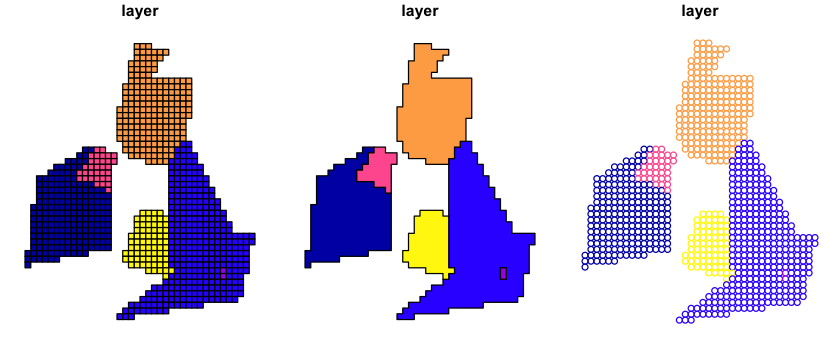

In [54]:
# rasterToPolygons returns a polygon for each cell and returns a Spatial object
poly_from_rast <- rasterToPolygons(uk_eire_poly_20km)
poly_from_rast <- as(poly_from_rast, 'sf')

# but can be set to dissolve the boundaries between cells with identical values
poly_from_rast_dissolve <- rasterToPolygons(uk_eire_poly_20km, dissolve=TRUE)
poly_from_rast_dissolve <- as(poly_from_rast_dissolve, 'sf')

# rasterToPoints returns a matrix of coordinates and values.
points_from_rast <- rasterToPoints(uk_eire_poly_20km)
points_from_rast <- st_as_sf(data.frame(points_from_rast), coords=c('x','y'))

# Plot the outputs - using key.pos=NULL to suppress the key and
# reset=FALSE to avoid plot.sf altering the par() options
par(mfrow=c(1,3), mar=c(1,1,1,1))
plot(poly_from_rast['layer'], key.pos = NULL, reset = FALSE)
plot(poly_from_rast_dissolve, key.pos = NULL, reset = FALSE)
plot(points_from_rast, key.pos = NULL, reset = FALSE)

It is uncommon to have raster data representing linear features (like `uk_eire_line_20km`) and it is not trivial to turn raster data into LINESTRING vector data. We won't look at this here.

## Using data in files

There are a huge range of different formats for spatial data. Fortunately, the `sf` and `raster` packages make life easy: the `st_read` function in `sf` reads most vector data and the `raster` function in `raster` reads most raster formats. There are odd file formats that are harder to read but most are covered by these two packages. The two packages also provide functions to save data to a file.

### Saving vector data

In [55]:
# This chunk removes existing demo outputs so they can be recreated in the following chunks
files <- dir('data', 'uk_eire*|uk_raster_*', full.names=TRUE)
print(files)
file.remove(files)

 [1] "data/uk_eire_BNG.dbf"          "data/uk_eire_BNG.prj"         
 [3] "data/uk_eire_BNG.shp"          "data/uk_eire_BNG.shx"         
 [5] "data/uk_eire_WGS84.dbf"        "data/uk_eire_WGS84.geojson"   
 [7] "data/uk_eire_WGS84.gpkg"       "data/uk_eire_WGS84.json"      
 [9] "data/uk_eire_WGS84.prj"        "data/uk_eire_WGS84.shp"       
[11] "data/uk_eire_WGS84.shx"        "data/uk_raster_BNG_interp.tif"
[13] "data/uk_raster_BNG_ngb.asc"   


[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

The most common vector data file format is the shapefile. This was developed by ESRI for use in ArcGIS but has become a common standard. We can save our `uk_eire` data to a shapfile using the `st_write` function from the `sf` package.

In [56]:
st_write(uk_eire, 'data/uk_eire_WGS84.shp')
st_write(uk_eire_BNG, 'data/uk_eire_BNG.shp')

Writing layer `uk_eire_WGS84' to data source `data/uk_eire_WGS84.shp' using driver `ESRI Shapefile'
Writing 6 features with 6 fields and geometry type Polygon.


Writing layer `uk_eire_BNG' to data source `data/uk_eire_BNG.shp' using driver `ESRI Shapefile'
Writing 6 features with 6 fields and geometry type Polygon.


If you look in the `data` directory, you see an irritating feature of the shapefile format: **a shapefile is not a single file**. A shapefile consists of a set of files: they all have the same name but different file suffixes and you need (at least) the files ending with `.prj`, `.shp`, `.shx` and `.dbf`, which is what `st_write` has created.

Other file formats are increasingly commonly used in place of the shapefile. ArcGIS has moved towards the personal geodatabase but more portable options are:

* GeoJSON stores the coordinates and attributes in a single text file: it is _technically_ human readable but you have to be familiar with JSON data structures. 
* GeoPackage stores vector data in a single SQLite3 database file. There are multiple tables inside this file holding various information about the data, but it is very portable and in a single file.

In [57]:
st_write(uk_eire, 'data/uk_eire_WGS84.geojson')
st_write(uk_eire, 'data/uk_eire_WGS84.gpkg')

Writing layer `uk_eire_WGS84' to data source `data/uk_eire_WGS84.geojson' using driver `GeoJSON'
Writing 6 features with 6 fields and geometry type Polygon.


Writing layer `uk_eire_WGS84' to data source `data/uk_eire_WGS84.gpkg' using driver `GPKG'
Writing 6 features with 6 fields and geometry type Polygon.


The `sf` package will try and choose the output format based on the file suffix (so `.shp` gives ESRI Shapefile). If you don't want to use the standard file suffix, you can also specify a **driver** directly: a driver is simply a bit of internal software that reads or writes a particular format and you can see the list of available formats using `st_drivers()`.

In [58]:
st_write(uk_eire, 'data/uk_eire_WGS84.json', driver='GeoJSON')

Writing layer `uk_eire_WGS84' to data source `data/uk_eire_WGS84.json' using driver `GeoJSON'
Writing 6 features with 6 fields and geometry type Polygon.


### Saving raster data

The GeoTIFF file format is one of the most common GIS raster data formats. It is basically the same as a TIFF image file but contains embedded data describing the origin, resolution and coordinate reference system of the data. Sometimes, you may also see a `.tfw` file: this is a 'world' file that contains the same information and you should probably keep it with the TIFF file. 

We can use the `writeRaster` function from the `raster` package to save our raster data. Again, the `raster` package will try and use the file name to choose a format but you can also use `format` to set the driver used to write the data: see `writeFormats()` for the options.

In [59]:
# Save a GeoTiff
writeRaster(uk_raster_BNG_interp, 'data/uk_raster_BNG_interp.tif')
# Save an ASCII format file: human readable text. 
# Note that this format does not contain the projection details!
writeRaster(uk_raster_BNG_ngb, 'data/uk_raster_BNG_ngb.asc', format='ascii')

### Loading Vector data

As an example here, we will use the 1:110m scale Natural Earth data on countries. The Natural Earth [website](https://www.naturalearthdata.com/) is a great open-source repository for lots of basic GIS data. It also has a R package that provides access to the data ([`rnaturalearth`](https://cran.r-project.org/web/packages/rnaturalearth/)), but in practice downloading and saving the specific files you want isn't that hard! 

We wil also use some downloaded WHO data. You will be unsurprised to hear that there is an R package to access this data ([`WHO`](https://cran.r-project.org/web/packages/WHO)) but we'll use a already downloaded copy.

In [60]:
# Load a vector shapefile
ne_110 <- st_read('data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')
# Also load some WHO data on 2016 life expectancy
# see: http://apps.who.int/gho/athena/api/GHO/WHOSIS_000001?filter=YEAR:2016;SEX:BTSX&format=csv
life_exp <- read.csv(file = "data/WHOSIS_000001.csv")

Reading layer `ne_110m_admin_0_countries' from data source `/Users/dorme/Teaching/GIS/Masters_GIS_2020/practicals/practical_1/data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp' using driver `ESRI Shapefile'
Simple feature collection with 177 features and 94 fields
geometry type:  MULTIPOLYGON
dimension:      XY
bbox:           xmin: -180 ymin: -90 xmax: 180 ymax: 83.64513
CRS:            4326


```{admonition} Create some global maps
Using the data loaded above, recreate the two plots shown below of global GDP and 2016 global life expectancy, averaged for both sexes. This only needs the plotting and merging skills from above.

The GDP data is already in the `ne_110` data, but you will need to add the life expectancy data to the GIS data. Getting country names to match between datasets is unexpectedly a common problem: try using the `ISO_A3_EH` field in `ne_110`. The other gotcha with merge is that, by default, the merge **drops rows** when there is no match. Here, it makes sense to use `all.x=TRUE` to retain all the countries: they will get NA values for the missing life expectancy.

The life expectancy plot has been altered to show less blocky colours in a nicer palette (`hcl.colors` uses the `viridis` palette by default). You will need to set the `breaks` and `pal` arguments to get this effect.
```

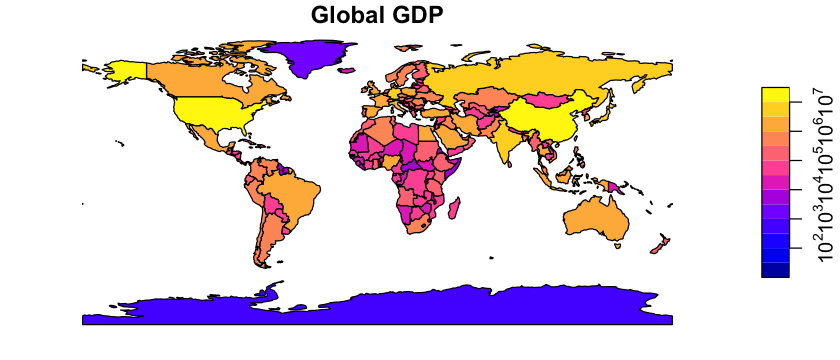

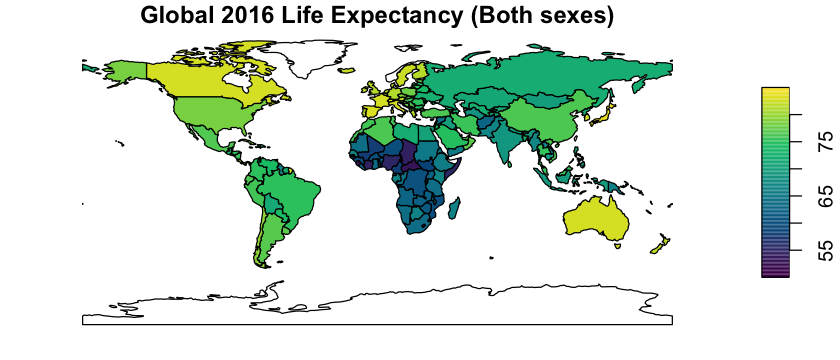

In [61]:
# Generate two stacked plots with narrow margins
par(mfrow=c(2,1), mar=c(1,1,1,1))

# The first plot is easy
plot(ne_110['GDP_MD_EST'],  asp=1, main='Global GDP', logz=TRUE, key.pos=4)

# Then for the second we need to merge the data
ne_110 <- merge(ne_110, life_exp, by.x='ISO_A3_EH', by.y='COUNTRY', all.x=TRUE)
# Create a sequence of break values to use for display
bks <- seq(50, 85, by=0.25)
# Plot the data
plot(ne_110['Numeric'], asp=1, main='Global 2016 Life Expectancy (Both sexes)',
      breaks=bks, pal=hcl.colors, key.pos=4)

### Loading XY data

We've looked at this case earlier, but one common source of vector data is a table with coordinates in it (either longitude and latitude for geographic coordinates or X and Y coordinates for a projected coordinate system). We will load some data like this and convert it into a proper `sf` object.  You do have to know the coordinate system!

In [62]:
# Read in Southern Ocean example data
so_data <- read.csv('data/Southern_Ocean.csv', header=TRUE)
head(so_data)
# Convert the data frame to an sf object
so_data <- st_as_sf(so_data, coords=c('long', 'lat'), crs=4326)
head(so_data)

,station,lat,long,krill_abun,chlorophyll
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,6,-59.90960,-53.03006,0.000000,1.0459308
2,8,-58.51637,-51.25974,0.000000,0.7963782
3,10,-59.91357,-49.41599,15.451699,0.8696133
4,12,-60.97059,-48.13545,58.635360,0.3670812
5,16,-57.97091,-42.93436,0.000000,0.9829019
6,19,-55.20345,-41.32185,1.606727,1.6252205


,station,krill_abun,chlorophyll,geometry
,<int>,<dbl>,<dbl>,<POINT [°]>
1,6,0.000000,1.0459308,POINT (-53.03006 -59.9096)
2,8,0.000000,0.7963782,POINT (-51.25974 -58.51637)
3,10,15.451699,0.8696133,POINT (-49.41599 -59.91357)
4,12,58.635360,0.3670812,POINT (-48.13545 -60.97059)
5,16,0.000000,0.9829019,POINT (-42.93436 -57.97091)
6,19,1.606727,1.6252205,POINT (-41.32185 -55.20345)


### Loading Raster data

We will look at some global topographic data taken from  the [ETOPO1](https://www.ngdc.noaa.gov/mgg/global/) dataset. The original data is at 1 arc minute (1/60°) and this file has been resampled to 15 arc minutes (0.25°) to make it a bit more manageable (466.7Mb to 2.7 Mb).

class      : RasterLayer 
dimensions : 720, 1440, 1036800  (nrow, ncol, ncell)
resolution : 0.25, 0.25  (x, y)
extent     : -180, 180, -90, 90  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0 
source     : /Users/dorme/Teaching/GIS/Masters_GIS_2020/practicals/practical_1/data/etopo_25.tif 
names      : etopo_25 
values     : -9295.364, 5930.763  (min, max)



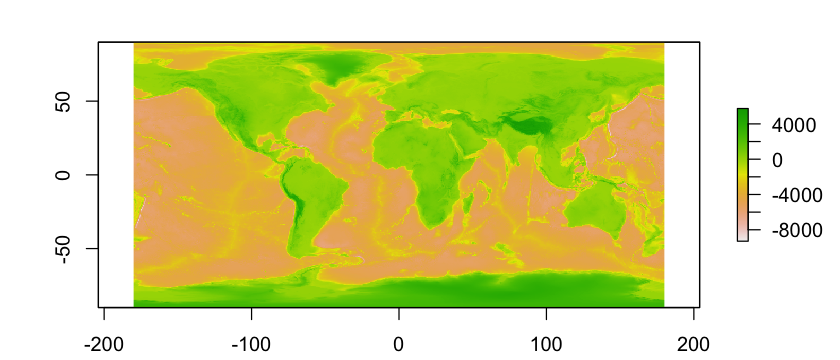

In [63]:
etopo_25 <- raster('data/etopo_25.tif')
# Look at the data content
print(etopo_25)
plot(etopo_25)

```{admonition} Controlling raster plots
That isn't a particularly useful colour scheme. Can you work out how to create the plot below? Some hints: you'll need to set breaks again and then provide two colour palettes that match the values either side of 0. The function `colorRampPalette` is really helpful here, or you could use the built-in palettes. 

You will also need to set the values that get labelled and their labels and this isn't obvious. It needs to be set in the plot command like this:  
```

``` R
axis.args=list(at=c(-10000, 0, 6000), lab=c(-10, 0, 6))
```

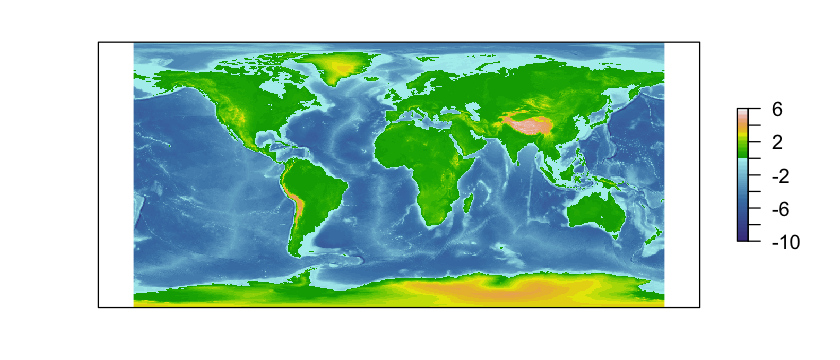

In [64]:
bks <- seq(-10000, 6000, by=250)
land_cols  <- terrain.colors(24)
sea_pal <- colorRampPalette(c('darkslateblue', 'steelblue', 'paleturquoise'))
sea_cols <- sea_pal(40)
plot(etopo_25, axes=FALSE, breaks=bks, col=c(sea_cols, land_cols), 
     axis.args=list(at=seq(-10000, 6000, by=2000), lab=seq(-10,6,by=2)))

### Raster Stacks

Raster data very often has multiple **bands**: a single file can contain multiple layers of information for the cells in the raster grid. An obvious example is colour imagery, where three layers hold red, green and blue values, but satellite data can contain many layers holding different bands.

We will use the `getData` function from the `raster` library to get at another example. This function loads data from some key data repositories (see `?getData` ). It will download the data automatically if needed and store it locally. Note that you only need to download the data once - as long as you tell `getData` where the files were stored, it will note that you have a local copy and load those, although it would be more usual just to use `raster` at this point! This data has already been downloaded to the `data` directory - `getData` will load it from the `data/wc10` folder.

We'll look at some worldclim data ([http://worldclim.org/version2](http://worldclim.org/version2)) for maximum temperature, which comes as a stack of monthly values.

In [65]:
# Download bioclim data: global maximum temperature at 10 arc minute resolution
tmax <- getData('worldclim', path='data', var='tmax', res=10)
# The data has 12 layers, one for each month
print(tmax)

class      : RasterStack 
dimensions : 900, 2160, 1944000, 12  (nrow, ncol, ncell, nlayers)
resolution : 0.1666667, 0.1666667  (x, y)
extent     : -180, 180, -60, 90  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0 
names      : tmax1, tmax2, tmax3, tmax4, tmax5, tmax6, tmax7, tmax8, tmax9, tmax10, tmax11, tmax12 
min values :  -478,  -421,  -422,  -335,  -190,   -94,   -59,   -76,  -153,   -265,   -373,   -452 
max values :   418,   414,   420,   429,   441,   467,   489,   474,   441,    401,    401,    413 



One odd thing about that data is the range of values: `-478` to `489`. It is _really common_ for GIS data to be stored in a form that needs scaling by the end user and this is what is going on here. The metadata for a raster data set should include any scale and offset values needed but you need to check that any variables you use are correctly scaled.

The reason to do this is to minimise disk use: `-478` to `489` can be stored really easily as integer data with 2 bytes per number (`Int16`). If it was stored as float data (with a decimal point), it would be 4 bytes per number (`Float32`) or worse (`Float64`).  So, the data file is half the size and - since the data is only accurate to 1 decimal place - we have no loss of precision. 

We can access different layers using ``[[``. We can also use aggregate functions (like `sum`, `mean`, `max` and `min`) to extract information across layers

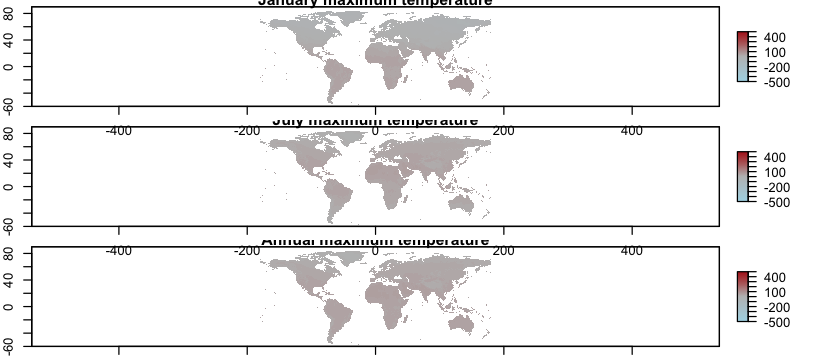

In [66]:
# scale the data
tmax <- tmax / 10
# Extract  January and July data and the annual maximum by location.
tmax_jan <- tmax[[1]]
tmax_jul <- tmax[[7]]
tmax_max <- max(tmax)
# Plot those maps
par(mfrow=c(3,1), mar=c(2,2,1,1))
bks <- seq(-500, 500, length=101)
pal <- colorRampPalette(c('lightblue','grey', 'firebrick'))
cols <- pal(100)
ax.args <- list(at= seq(-500, 500, by=100))
plot(tmax_jan, col=cols, breaks=bks, axis.args=ax.args, main='January maximum temperature')
plot(tmax_jul, col=cols, breaks=bks, axis.args=ax.args, main='July maximum temperature')
plot(tmax_max, col=cols, breaks=bks, , axis.args=ax.args, main='Annual maximum temperature')

## Overlaying raster and vector data

In this next exercise, we are going to use some data to build up a more complex map of chlorophyll concentrations in the Southern Ocean. There are a few new techniques along the way.

### Cropping data

Sometimes you are only interested in a subset of the area covered by a GIS dataset. Cropping the data to the area of interest can make plotting easier and can also make GIS operations a lot faster, particularly if the data is complex.

In [67]:
so_extent <- extent(-60, -20, -65, -45)
# The crop function for raster data...
so_topo <- crop(etopo_25, so_extent)
# ... and the st_crop function to reduce some higher resolution coastline data
ne_10 <- st_read('data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')
st_agr(ne_10) <- 'constant'
so_ne_10 <- st_crop(ne_10, so_extent)

Reading layer `ne_10m_admin_0_countries' from data source `/Users/dorme/Teaching/GIS/Masters_GIS_2020/practicals/practical_1/data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp' using driver `ESRI Shapefile'
Simple feature collection with 255 features and 94 fields
geometry type:  MULTIPOLYGON
dimension:      XY
bbox:           xmin: -180 ymin: -90 xmax: 180 ymax: 83.6341
CRS:            4326


although coordinates are longitude/latitude, st_intersection assumes that they are planar



```{admonition} Plotting Southern Ocean chlorophyll
Using the data loaded above, recreate this map. For continuous raster data, contours can help make the data a bit clearer or replace a legend and are easy to add using the `contour` function with a raster object.
```

ERROR: Error in plot.sf(so_data["chlorophyll"], add = TRUE, logz = TRUE, pch = 20, : object 'viridis' not found


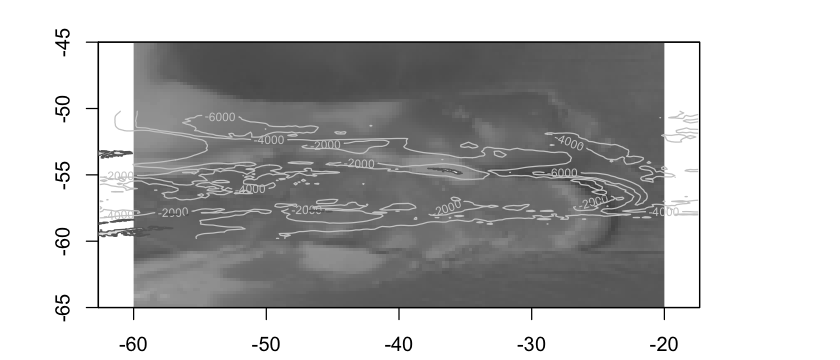

In [68]:
sea_pal <- colorRampPalette(c('grey30', 'grey50', 'grey70'))
plot(so_topo, col=sea_pal(100), asp=1, legend=FALSE)
contour(so_topo, levels=c(-2000, -4000, -6000), add=TRUE, col='grey80')
plot(st_geometry(so_ne_10), add=TRUE, col='grey90', border='grey40')
plot(so_data['chlorophyll'], add=TRUE, logz=TRUE, pch=20, cex=2, pal=viridis, border='white', reset=FALSE)
.image_scale(log10(so_data$chlorophyll), col=hcl.colors(18), key.length=0.8, key.pos=4, logz=TRUE)

## Spatial joins and raster data extraction

### Spatial joining

We have merged data into an `sf` object by matching values in columns, but we can also merge data **spatially**. This process is often called a **spatial join**.

As an example, we are going to look at mapping 'mosquito outbreaks' in Africa: we are actually going to use some random data, mostly to demonstrate the useful `st_sample` function. We would like to find out whether any countries are more severely impacted in terms of both the area of the country and their population size.

In [ ]:
set.seed(1)
# extract Africa from the ne_110 data and keep the columns we want to use
africa <- subset(ne_110, CONTINENT=='Africa', select=c('ADMIN', 'POP_EST'))

# transform to the Robinson projection
africa <- st_transform(africa, crs=54030)
# create a random sample of points
mosquito_points <- st_sample(africa, 1000)

# Create the plot
plot(st_geometry(africa), col='khaki')
plot(mosquito_points, col='firebrick', add=TRUE)

In order to join these data together we need to turn the `mosquito_points` object from a geometry column (`sfc`) into a full `sf` data frame, so it can have attributes and then we can simply add the country name ('ADMIN') onto the points.

In [ ]:
mosquito_points <- st_sf(mosquito_points)
mosquito_points <- st_join(mosquito_points, africa['ADMIN'])

plot(st_geometry(africa), col='khaki')
plot(mosquito_points['ADMIN'], add=TRUE)

We can now aggregate the points within countries. This can give us a count of the number of points in each country and also converts multiple rows of `POINT` into a single `MULTIPOINT` feature per country.

In [ ]:
mosquito_points_agg <- aggregate(mosquito_points, by=list(country=mosquito_points$ADMIN), FUN=length)
names(mosquito_points_agg)[2] <-'n_outbreaks'
head(mosquito_points_agg)

In [ ]:
africa <- st_join(africa, mosquito_points_agg)
africa$area <- as.numeric(st_area(africa))
head(africa)

In [ ]:
par(mfrow=c(1,2), mar=c(3,3,1,1), mgp=c(2,1, 0))
plot(n_outbreaks ~ POP_EST, data=africa, log='xy', 
     ylab='Number of outbreaks', xlab='Population size')
plot(n_outbreaks ~ area, data=africa, log='xy',
     ylab='Number of outbreaks', xlab='Area (m2)')

```{admonition} Alien invasion

Martians have invaded! Jeff and Will have managed to steal the landing sites and the crew sizes from the alien mothership but we need to work out which countries are going to be overwhelmed by aliens. We think that countries with more than about 1000 people per alien are going to be ok, but we need a map of alien threat like the one below. The landing sites are in the file `data/aliens.csv` as WGS84 coordinates.

Can you produce our plan?
```

In [ ]:
# Load the data and convert to a sf object
alien_xy <- read.csv('data/aliens.csv')
alien_xy <- st_as_sf(alien_xy, coords=c('long','lat'), crs=4326)

# Add country information and find the total number of aliens per country
alien_xy <- st_join(alien_xy, ne_110['ADMIN'])
aliens_by_country <- aggregate(n_aliens ~ ADMIN, data=alien_xy, FUN=sum)

# Add the alien counts into the country data 
ne_110 <- merge(ne_110, aliens_by_country, all.x=TRUE)
ne_110$aliens_per_capita <- with(ne_110,  n_aliens / POP_EST)

# create the scale colours
bks <- seq(-8, 2, length=101)
pal <- colorRampPalette(c('darkblue','lightblue', 'salmon','darkred'))

plot(ne_110['aliens_per_capita'], logz=TRUE, breaks=bks, pal=pal, key.pos=4)

### Extracting data from Rasters

The spatial join above allows us to connect vector data based on location but you might also need to extract data from a raster dataset in certain locations. Examples include to know the
exact altitude or surface temperature of sampling sites or average values within a polygon. We are going to use a chunk of the full resolution ETOPO1 elevation data to explore this.

In [ ]:
uk_eire_etopo <- raster('data/etopo_uk.tif')

```{admonition} Masking elevation data

Before we can do this, ETOPO data include bathymetry as well as elevation. Use the `rasterize` function on the high resolution `ne_10` dataset to get a land raster matching `uk_eire_etopo` and then use the `mask` function to create the elevation map. You should end up with the following data.
```

In [ ]:
uk_eire_detail <- subset(ne_10, ADMIN %in% c('United Kingdom', "Ireland"))
uk_eire_detail_raster <- rasterize(as(uk_eire_detail, 'Spatial'), uk_eire_etopo)
uk_eire_elev <- mask(uk_eire_etopo, uk_eire_detail_raster)

par(mfrow=c(1,2), mar=c(3,3,1,1), mgp=c(2,1,0))
plot(uk_eire_etopo, axis.args=list(las=3))
plot(uk_eire_elev, axis.args=list(las=3))
plot(st_geometry(uk_eire_detail), add=TRUE, border='grey')

### Raster cell statistics and locations

The `cellStats` function provides a way summarize the data in a raster. We can also find out the locations of cells with particular characteristics using, for example, `Which` (note the capital letter!) and `which.max`. Both of those functions return cell ID numbers, but the `xyFromCell` allows you to turn those ID numbers into coordinates.

In [ ]:
cellStats(uk_eire_elev, max)
cellStats(uk_eire_elev, quantile)
# Which is the highest cell
which.max(uk_eire_elev)

In [ ]:
# Which cells are above 1100m
Which(uk_eire_elev > 1100, cells=TRUE)

```{admonition} Highlight highest point and areas below sea level
Plot the locations of the maximum altitude and cells below sea level on the map. Some questions about the result:

* Is the maximum altitude the _real_ maximum altitude in the UK? If not, why not? 
* Why do so many points have elevations below sea level? There are two reasons!
```

In [ ]:
max_cell <- which.max(uk_eire_elev)
max_xy <- xyFromCell(uk_eire_elev, max_cell)
max_sfc<- st_sfc(st_point(max_xy), crs=4326)
bsl_cell <- Which(uk_eire_elev < 0, cells=TRUE)
bsl_xy <- xyFromCell(uk_eire_elev, bsl_cell)
bsl_sfc <- st_sfc(st_multipoint(bsl_xy), crs=4326)

plot(uk_eire_elev, axis.args=list(las=3))
plot(max_sfc, add=TRUE, pch=24, bg='red')
plot(bsl_sfc, add=TRUE, pch=25, bg='lightblue', cex=0.6)

### The extract function

The previous section shows the basic functions needed to get at raster data but the `extract` function makes it easier. It works in different ways on different geometry types:

* POINT: extract the values under the points.
* LINESTRING: extract the values under the linestring
* POLYGON: extract the values within the polygon

Extracting raster values under points is really easy.

In [ ]:
uk_eire_capitals$elev <- extract(uk_eire_elev, uk_eire_capitals)
print(uk_eire_capitals)

Polygons are also easy but there is a little more detail about the output. By default, the `extract` function for polygons returns a set of *all* the raster values within each polygon. However, you can use the `fun` argument to specify that `extract` does something with those values. This  effectively duplicates the extremely useful **Zonal Statistics** function from other GIS programs.

In [ ]:
uk_eire$mean_height <- extract(uk_eire_elev, uk_eire, fun=mean, na.rm=TRUE)
uk_eire

Extracting values under linestrings is more complicated. The basic option works in the same way - the function returns the values underneath the line. If you want to tie the values to locations on the line then you need to work a bit harder:

* By default, the function just gives the sample of values under the line, in no particular order. The `along=TRUE` argument preserves the order along the line.
* It is also useful to able to know _which_ cell gives each value. The `cellnumbers=TRUE` argument allow us to retrieve this information. 

 We are going to get a elevation transect for the [Pennine Way](https://www.nationaltrail.co.uk/pennine-way): a 429 km trail across some of the wildest bits of England. The data for the trail comes as a GPX file, commonly used in GPS receivers. 

One feature of GPX files is that they contain multiple **layers**: essentially different GIS datasets within a single source. The `st_layers` function allows us to see the names of those layers so we can load the one we want.

In [ ]:
st_layers('data/National_Trails_Pennine_Way.gpx')
# load the data, showing off the ability to use SQL queries to load subsets of the data
pennine_way <- st_read('data/National_Trails_Pennine_Way.gpx', layer='routes', 
                      query="select * from routes where name='Pennine Way'")

Before we do anything else, all of our data (`etopo_uk` and `pennine_way`) are in WGS84. It really does not make sense to calculate distances and transects on a geographic coordinate system so:


```{admonition} Reproject the Penine Way
Create `uk_eire_elev_BNG` and `pennine_way_BNG` by reprojecting the elevation raster and route vector into the British National Grid. Use a 2km resolution grid.
```

In [ ]:
# reproject the vector data
pennine_way_BNG <- st_transform(pennine_way, crs=27700)
# create the target raster and project the elevation data into it.
bng_2km <- raster(xmn=-200000, xmx=700000, ymn=0, ymx=1000000, 
                  res=2000, crs='+init=EPSG:27700')
uk_eire_elev_BNG <- projectRaster(uk_eire_elev, bng_2km)

The route data is also very detailed, which is great if you are navigating in a blizzard but does take a long time to process for this exercise. So, we'll also simplify the route data before we use it. We'll use a 100m tolerance for simplifying the route: it goes from 31569 points to 1512 points. You can see the difference on the two plots below and this is worth remembering: **do you really need to use the highest resolution data available**?

In [ ]:
# Simplify the data
pennine_way_BNG_simple <- st_simplify(pennine_way_BNG,  dTolerance=100)

# Zoom in to the whole route and plot the data
par(mfrow=c(1,2), mar=c(1,1,1,1))

plot(uk_eire_elev_BNG, xlim=c(3e5, 5e5), ylim=c(3.8e5, 6.3e5),
     axes=FALSE, legend=FALSE)
plot(st_geometry(pennine_way_BNG), add=TRUE, col='black')
plot(pennine_way_BNG_simple, add=TRUE, col='darkred')

# Add a zoom box and use that to create a new plot
zoom <- extent(3.77e5, 3.89e5, 4.7e5, 4.85e5)
plot(zoom, add=TRUE)

# Zoomed in plot
plot(uk_eire_elev_BNG, ext=zoom, axes=FALSE, legend=FALSE)
plot(st_geometry(pennine_way_BNG), add=TRUE, col='black')
plot(pennine_way_BNG_simple, add=TRUE, col='darkred')

Now we can extract the elevations and cell IDs under the route. We can also simply use Pythagoras' Theorem to find the distance between cells along the transect and hence the cumulative distance.

In [ ]:
# Extract the data
pennine_way_trans <- extract(uk_eire_elev_BNG, pennine_way_BNG_simple, 
                             along=TRUE, cellnumbers=TRUE)

# The output is a list: in will contain one set of values for each feature in the input data
str(pennine_way_trans)

# Here, we only have one line, so we will extract it
pennine_way_trans <- pennine_way_trans[[1]]
pennine_way_trans <- data.frame(pennine_way_trans)

# Get the cell coordinates 
pennine_way_xy <- xyFromCell(uk_eire_elev_BNG, pennine_way_trans$cell)
pennine_way_trans <- cbind(pennine_way_trans, pennine_way_xy)

# Now we can use Pythagoras to find the distance along the transect
pennine_way_trans$dx <- c(0, diff(pennine_way_trans$x))
pennine_way_trans$dy <- c(0, diff(pennine_way_trans$y))
pennine_way_trans$distance_from_last <- with(pennine_way_trans, sqrt(dx^2 + dy^2))
pennine_way_trans$distance <- cumsum(pennine_way_trans$distance_from_last)

plot( etopo_uk ~ distance, data=pennine_way_trans, type='l', 
     ylab='Elevation (m)', xlab='Distance (m)')

## Mini projects

You should now have the skills to tackle the miniproject below. Give them a go - the answers are still available but try and puzzle it out.

### Precipitation transect for  New Guinea

```{admonition} Create a total annual precipitation transect for New Guinea
*  Use the 0.5 arc minute worldclim data from `getData` - you will need to specify a location to get the tile including New Guinea. 
* Use UTM 54S ([https://epsg.io/32754](https://epsg.io/32754)) and use a 1 km resolution to reproject raster data. You will need to find an extent in UTM 54S to cover the study area and choose extent coordinates to create neat 1km cell boundaries
* Create a transect with the following (WGS84 Long + Lat) coordinates: 

    ``` r
    transect_long <- c(132.3, 135.2, 146.4, 149.3)
    transect_lat <- c(-1, -3.9, -7.7, -9.8)
    ```
   
   You will need to reproject the transect into UTM 54S and then use the function `st_segmentize` to create regular 1000m sampling points along the transect.

Note that some of these steps are handling a lot of data and may take a few minutes to complete. 
```

In [ ]:
# Get the precipitation data
ng_prec <- getData('worldclim', var='prec', res=0.5, lon=140, lat=-10, path='data')
# Reduce to the extent of New Guinea - crop early to avoid unnecessary processing!
ng_extent <- extent(130, 150, -10, 0)
ng_prec <- crop(ng_prec, ng_extent)
# Calculate annual precipitation
ng_annual_prec <- sum(ng_prec)

# Now reproject to UTM 54S. The code here is using reprojecting the extent of the
# raster data to get sensible values for the UTM 54S extent. We are picking extent 
# values here that create a neat 1000m grid with sensible cell edges
ng_extent_poly <- st_as_sfc(st_bbox(ng_extent, crs=4326))
st_transform(ng_extent_poly, crs=32754)
ng_extent_utm <- extent(-732000, 1506000, 8874000, 10000000)

# Create the raster and reproject the data
ng_template_utm <- raster(ng_extent_utm, res=1000, crs="+init=EPSG:32754")
ng_annual_prec_utm <- projectRaster(ng_annual_prec, ng_template_utm)

# Create and reproject the transect and then segmentize it to 1000m
transect <-  st_linestring(cbind(x=transect_long, y=transect_lat))
transect <- st_sfc(transect, crs=4326)
transect_utm <- st_transform(transect, crs=32754)
transect_utm <- st_segmentize(transect_utm, dfMaxLength=1000)

transect_data <- extract(ng_annual_prec_utm, as(transect_utm, 'Spatial'), 
                             along=TRUE, cellnumbers=TRUE)

# Get the first item from the transect data 
transect_data <- transect_data[[1]]
transect_data <- data.frame(transect_data)

# Get the cell coordinates 
transect_data_xy <- xyFromCell(ng_annual_prec_utm, transect_data$cell)
transect_data <- cbind(transect_data, transect_data_xy)

# Now we can use Pythagoras to find the distance along the transect
transect_data$dx <- c(0, diff(transect_data$x))
transect_data$dy <- c(0, diff(transect_data$y))
transect_data$distance_from_last <- with(transect_data, sqrt(dx^2 + dy^2))
transect_data$distance <- cumsum(transect_data$distance_from_last)

# Get the natural earth high resolution coastline.
ne_10_ng  <- st_crop(ne_10, ng_extent_poly)
ne_10_ng_utm <-  st_transform(ne_10_ng, crs=32754)

par(mfrow=c(2,1), mar=c(3,3,1,1), mgp=c(2,1,0))
plot(ng_annual_prec_utm)
plot(ne_10_ng_utm, add=TRUE, col=NA, border='grey50')
plot(transect_utm, add=TRUE)

par(mar=c(3,3,1,1))
plot( layer ~ distance, data=transect_data, type='l', 
     ylab='Annual precipitation (mm)', xlab='Distance (m)')

### Fishing pressure in Fiji

This exercise is quite a bit harder - you will probably need to read more help files (or peek at the code) but see how you go!

Researchers have identified 7 commonly used fishing sites around the island of Kadavu in Fiji. The have also conducted surveys of the coastal villages known to use these sites and are trying to identify how many households are likely to use site. We are going to use the simplifying assumption that each village will _always_ use the closest site.

We can't just use `st_distance` because we need the distances to reflect travel distances through the sea rather than straight line distances. So we are going to need to use a new tool: **cost distance analysis**. Cost distance models use a raster to define a cost surface: moving from a cell to a neighbouring cell has a cost which is derived from the values in the raster. This gives us a way to ask what the cost of getting from A to B is, where movement is allowed to avoid areas that are expensive to traverse.
 
We're also going to be using some data in an Excel file. It is really common to use Excel to arrange and manage data tables. If you use R you then typically end up exporting CSVs to load, but there is a better way: read the data directly from Excel. This means that you don't have to maintain multiple versions of the same data in different formats. 

```r
install.packages('gdistance') # Cost distance analysis
install.packages('openxlsx') # Load data from Excel directly
```

In [ ]:
library(gdistance)
library(openxlsx)

#### Loading the data

* Use `getData` to obtain the GADM Level 2 vector data for Fiji (`country='FJI'`) and then extract Kadavu.
* Use `readWorbook` to load the data from each of the `Villages` and `Field sites` worksheets from the `FishingPressure.xlsx` spreadsheet and convert those tables into  `sf`  objects with POINT data.
* All of those data are in WGS84 coordinates, so convert them to a projection system appropriate to Fiji (UTM 60S: EPSG:32760).

In [ ]:
# Download the GADM data for Fiji, convert to sf and then extract Kadavu
fiji <- getData('GADM', country='FJI', level=2, path='data')
fiji <- st_as_sf(fiji)
kadavu <- subset(fiji, NAME_2 == 'Kadavu')

# Load the villages and sites and convert to sf
villages <- readWorkbook('data/FishingPressure.xlsx', 'Villages')
villages <- st_as_sf(villages, coords=c('long','lat'), crs=4326)
sites <- readWorkbook('data/FishingPressure.xlsx', 'Field sites', startRow=3)
sites <- st_as_sf(sites, coords=c('Long','Lat'), crs=4326)

# Reproject the data UTM60S
kadavu <- st_transform(kadavu, 32760)
villages <- st_transform(villages, 32760)
sites <- st_transform(sites, 32760)

# Map to check everything look right.
plot(st_geometry(sites), axes=TRUE, col='blue')
plot(st_geometry(villages), add=TRUE, col='red')
plot(st_geometry(kadavu), add=TRUE)

#### Create the cost surface

The cost surface should assign a uniform cost to moving through the sea and an infinite cost (`NA`) to moving over land. The resolution of your cost surface raster matters: a very fine resolution will give very precise distances but take a long time to run;  a coarse resolution will run quickly but the distances will be very crude. So, you need to:

* pick extents to cover the islands and sites.,
* pick a resolution,
* use `st_rasterize` to convert the vector coastline into a raster and create the surface. 

Remember from above the difference between rasterizing a polygon and a linestring: cells containing coastline contain sea so should be available for movement.

In [ ]:
# Create a template raster covering the whole study area, at a given resolution
res <- 100
r <- raster(xmn=590000, xmx=670000, ymn=7870000, ymx=7940000, crs=32760, res=res)

# Rasterize the island as a POLYGON to get cells that cannot be traversed
kadavu_poly <- rasterize(as(kadavu, 'Spatial'), r, 
                         field=1, background=0)
# Rasterize the island as a MULTILINESTRING to get the coastal 
# cells that _can_ be traversed
kadavu_lines <- rasterize(as(st_cast(kadavu, 'MULTILINESTRING'), 'Spatial'), r, 
                         field=1, background=0)

# Combine those to give cells that are in the sea (kadavu_poly=0) or in the coast (kadavu_lines=1)
sea_r <- (! kadavu_poly) | kadavu_lines

# Set the costs
sea_r[sea_r == 0] <- NA
sea_r[! is.na(sea_r)] <- 1
plot(sea_r)

#### Finding launch points

The villages are not all on the coast! If the village is too far inland then it may sit in a cell with an infinite travel cost. So we need to find the closest point on the coast to each village using `st_nearest_points`. All points within a polygon are part of that polygon, so we have to explicitly convert the island polygon to a MULTILINESTRING showing the coast to find point on the coast.

The output of `st_nearest_points` is a line that joins each village point to the nearest point on the coast. The second points on each of these lines are our nearest launch points and we can use `st_line_sample` with `sample=1` to extract them.

In [ ]:
# Find the nearest points on the coast to each village
village_coast <- st_nearest_points(villages, st_cast(kadavu, 'MULTILINESTRING'))
# Extract the end point on the coast and convert from MULTIPOINT to POINT
launch_points <- st_line_sample(village_coast, sample=1)
launch_points <- st_cast(launch_points, 'POINT')

# Zoom in to a bay on Kadavu
plot(st_geometry(kadavu), xlim=c(616000, 618000), ylim=c(7889000, 7891000), col='khaki')
 # Plot the villages, lines to the nearest coast and the launch points.
plot(st_geometry(villages), add=TRUE, col='firebrick')
plot(village_coast, add=TRUE, col='grey')
plot(launch_points, add=TRUE, col='darkgreen')

We can add the launch points in to our `villages` object. It is possible to have more than one geometry associated with a row of data: you just have to set which one is being used.

In [ ]:
villages$launch_points <- launch_points
st_geometry(villages) <- 'launch_points'

#### Find distances

This is a really hard bit because the way the `costDistance` function work is quite complex. The first step is to use `transition` to create a transition graph. This sets:

1. Which cells are connected to each other: common options are `directions=4` (rook's move), `directions=8` (queen's move) and `directions=16` (knight's move).

In [ ]:
r <- raster(matrix(0, ncol=5, nrow=5))
r[13] <- 2
# rook, queen and knight cells from the centre cell (13)
# - the output is a matrix with the second column showing the neighbours
rook <- adjacent(r, 13, direction=4)[,2]
queen <- adjacent(r, 13, direction=8)[,2]
knight <- adjacent(r, 13, direction=16)[,2]
# plot those
par(mfrow=c(1,3), mar=c(1,1,1,1))
r[rook] <- 1
plot(r)
r[queen] <- 1
plot(r)
r[knight] <- 1
plot(r)

2. What the cost of moving between connected cells are by applying a function to the values in the two connected cells.

However, `transition` just creates the network and assigns the basic transition values between cells. In a GIS setting, we also need to scale the costs by the physical distances between cells, using `geoCorrection`. We can then use `costDistance` to find the distances between sites and launch points through the transition network.

In [ ]:
tr <- transition(sea_r, transitionFunction=mean, directions=8)
tr <- geoCorrection(tr)

# Now we can calculate the cost distance for each launch point to each site
costs <- costDistance(tr, as(villages, 'Spatial'), as(sites, 'Spatial'))

#### Assign villages to sites

The result of `costDistance` is a matrix showing the calculated distance through the sea from each launch point to each site. All we need to do now is find the nearest site to each village, count up households per site and merge that information into the sites.

In [ ]:
# Find the index and name of the lowest distance in each row
villages$nearest_site_index <- apply(costs, 1, which.min)
villages$nearest_site_name  <- sites$Name[villages$nearest_site_index]

# Find the total number of buildings  per site and merge that data
# into the sites object
site_load <- aggregate(building_count ~ nearest_site_name, data=villages, FUN=sum)
sites <- merge(sites, site_load, by.x='Name', by.y='nearest_site_name', all.x=TRUE)

# Now build up a complex plot
plot(st_geometry(kadavu))
# add the villages, colouring by nearest site and showing the village 
# size using the symbol size (cex)
plot(villages['nearest_site_name'], add=TRUE,  cex=log10(villages$building_count))
# Add the sites and label with site name and building count
plot(st_geometry(sites), add=TRUE, col='red')
labels <- with(sites, sprintf('%s: %s', Name, building_count))
text(st_coordinates(sites), label=labels, cex=0.7, pos=c(3,3,3,3,3,3,1))

# Add the path for each village to its nearest site
for(idx in seq(nrow(villages))){
	this_village <- as(villages[idx, ], 'Spatial')
	this_village_site <- as(sites[this_village$nearest_site_index, ], 'Spatial')
	journey <- shortestPath(tr, this_village, this_village_site, output='SpatialLines')
	plot(st_as_sfc(journey), add=TRUE, col='grey')
}

## Using ggplot to make maps

As you will have seen in the last couple of weeks, `ggplot` is a popular package for plotting and can be used for with `sf` objects in maps too. There is also a package called `tmap` which works in a very similar way to `ggplot` but is more tightly focussed on map plotting. If you end up creating lots of maps, that might be a good place to look.  Essentially GIS maps are mostly about deciding what information you want to show and the plot order, so the simple plotting we use here can be pretty good without needing extra tools.

Having said that, here is a `ggplot` map of the world.

In [ ]:
library(ggplot2)
ggplot(ne_110) +
       geom_sf() +
       theme_bw()

There are several `ggplot` extensions for `sf` that make it easier to colour and label your `ggplot` maps.

In [ ]:
europe <- st_crop(ne_110, extent(-10,40,35,75))
ggplot(europe) +
       geom_sf(aes(fill=log(GDP_MD_EST))) +
       scale_fill_viridis_c() +
       theme_bw() + 
       geom_sf_text(aes(label = ADMIN), pointsize=9, colour = "grey20")

```{admonition} European life expectancy

Can you update the code above to create the map below of European life expectancy. Note that the map is now in a projected coordinate system: [ETRS89 / LAEA Europe](http://epsg.io/3035) (EPSG: 3035).
```

In [ ]:
europe_laea <- st_transform(europe, 3035)
ggplot(europe_laea) +
       geom_sf(aes(fill=Numeric)) +
       scale_fill_viridis_c() +
       theme_bw()

What is wrong with that map? Can you fix it?

## Colour palettes

Colour palettes are an essential part of presenting spatial data, as often we
read the data as a colour scale on a map, rather than an x- or y-axis of
continuous variables. There has been a lot of discussion amongst researches on
the best colour scales to use. Rainbow colours used to be a the most common
used, but are not appropriate for colour blindness and interpreting the data
can be hard. Rainbow can be found amongst the R base colours, but I would not
recommend using them as there are plenty more better options.

![R base colour palettes.](images/rbase.png)

The `hcl.colors` function - as used above - is a far better choice in many cases. There are a wide range of palettes (see `hcl.pals()`) with different use cases. There are also some specific packages that provide extra colour schemes.

### Viridis

The `viridis` package contains the `viridis` palette, but also these other palettes:

![Colour palettes from the viridis package.](images/viridis.png)

Re-plot the life expectancy map of Europe using each of the other 3 palettes in
the `viridis` pacakge. Which one do you prefer?

With `ggplot`, you can use the functions `scale_color_viridis()` to colour points, lines or
texts and `scale_fill_viridis()` to fill areas. Use the `option` argument to
select which pallette in `viridis` you wish, with the viridis palette being the
default.

### Brewer

In [ ]:
library(RColorBrewer)
display.brewer.all()

The first group are spectral palettes that are most similar to `viridis` and
good for representing continous data. The second group are qualitative palettes
which should be used for categorical data (e.g. bar plots) and the final group
put equal emphasis on the mid-range values as well as those at the end. These
should be used when representing changes a value, e.g. temperature, where the
white middle colour shows no change has occurred in the data.

The brewer packages has a neat way of showing colours that are
colourblind-friendly.

In [ ]:
display.brewer.all(colorblindFriendly = TRUE)

As with `viridis` you can use `scale_color_brewer()` and `scale_fill_brewer()`
in `ggplot`.



<!-- ## Extensions

### GIF of WHO data
Make a GIF which mapping the time series of the global life expectancy for all countries from 2000 to 2016. Hint use the `tmap` package and `tmap_animation()`. See the 'Geocomputation in R' book for more information. -->